In [1]:
import datetime
import os
from os import listdir
from os.path import isfile, join
import logging
from datetime import date

from pathlib import Path
import seismographer_utils as seisproc

import numpy as np
import pandas as pd
import scipy as sp
import json

import pandas as pd


# use 100% of width in this notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<IPython.core.display.Javascript object>


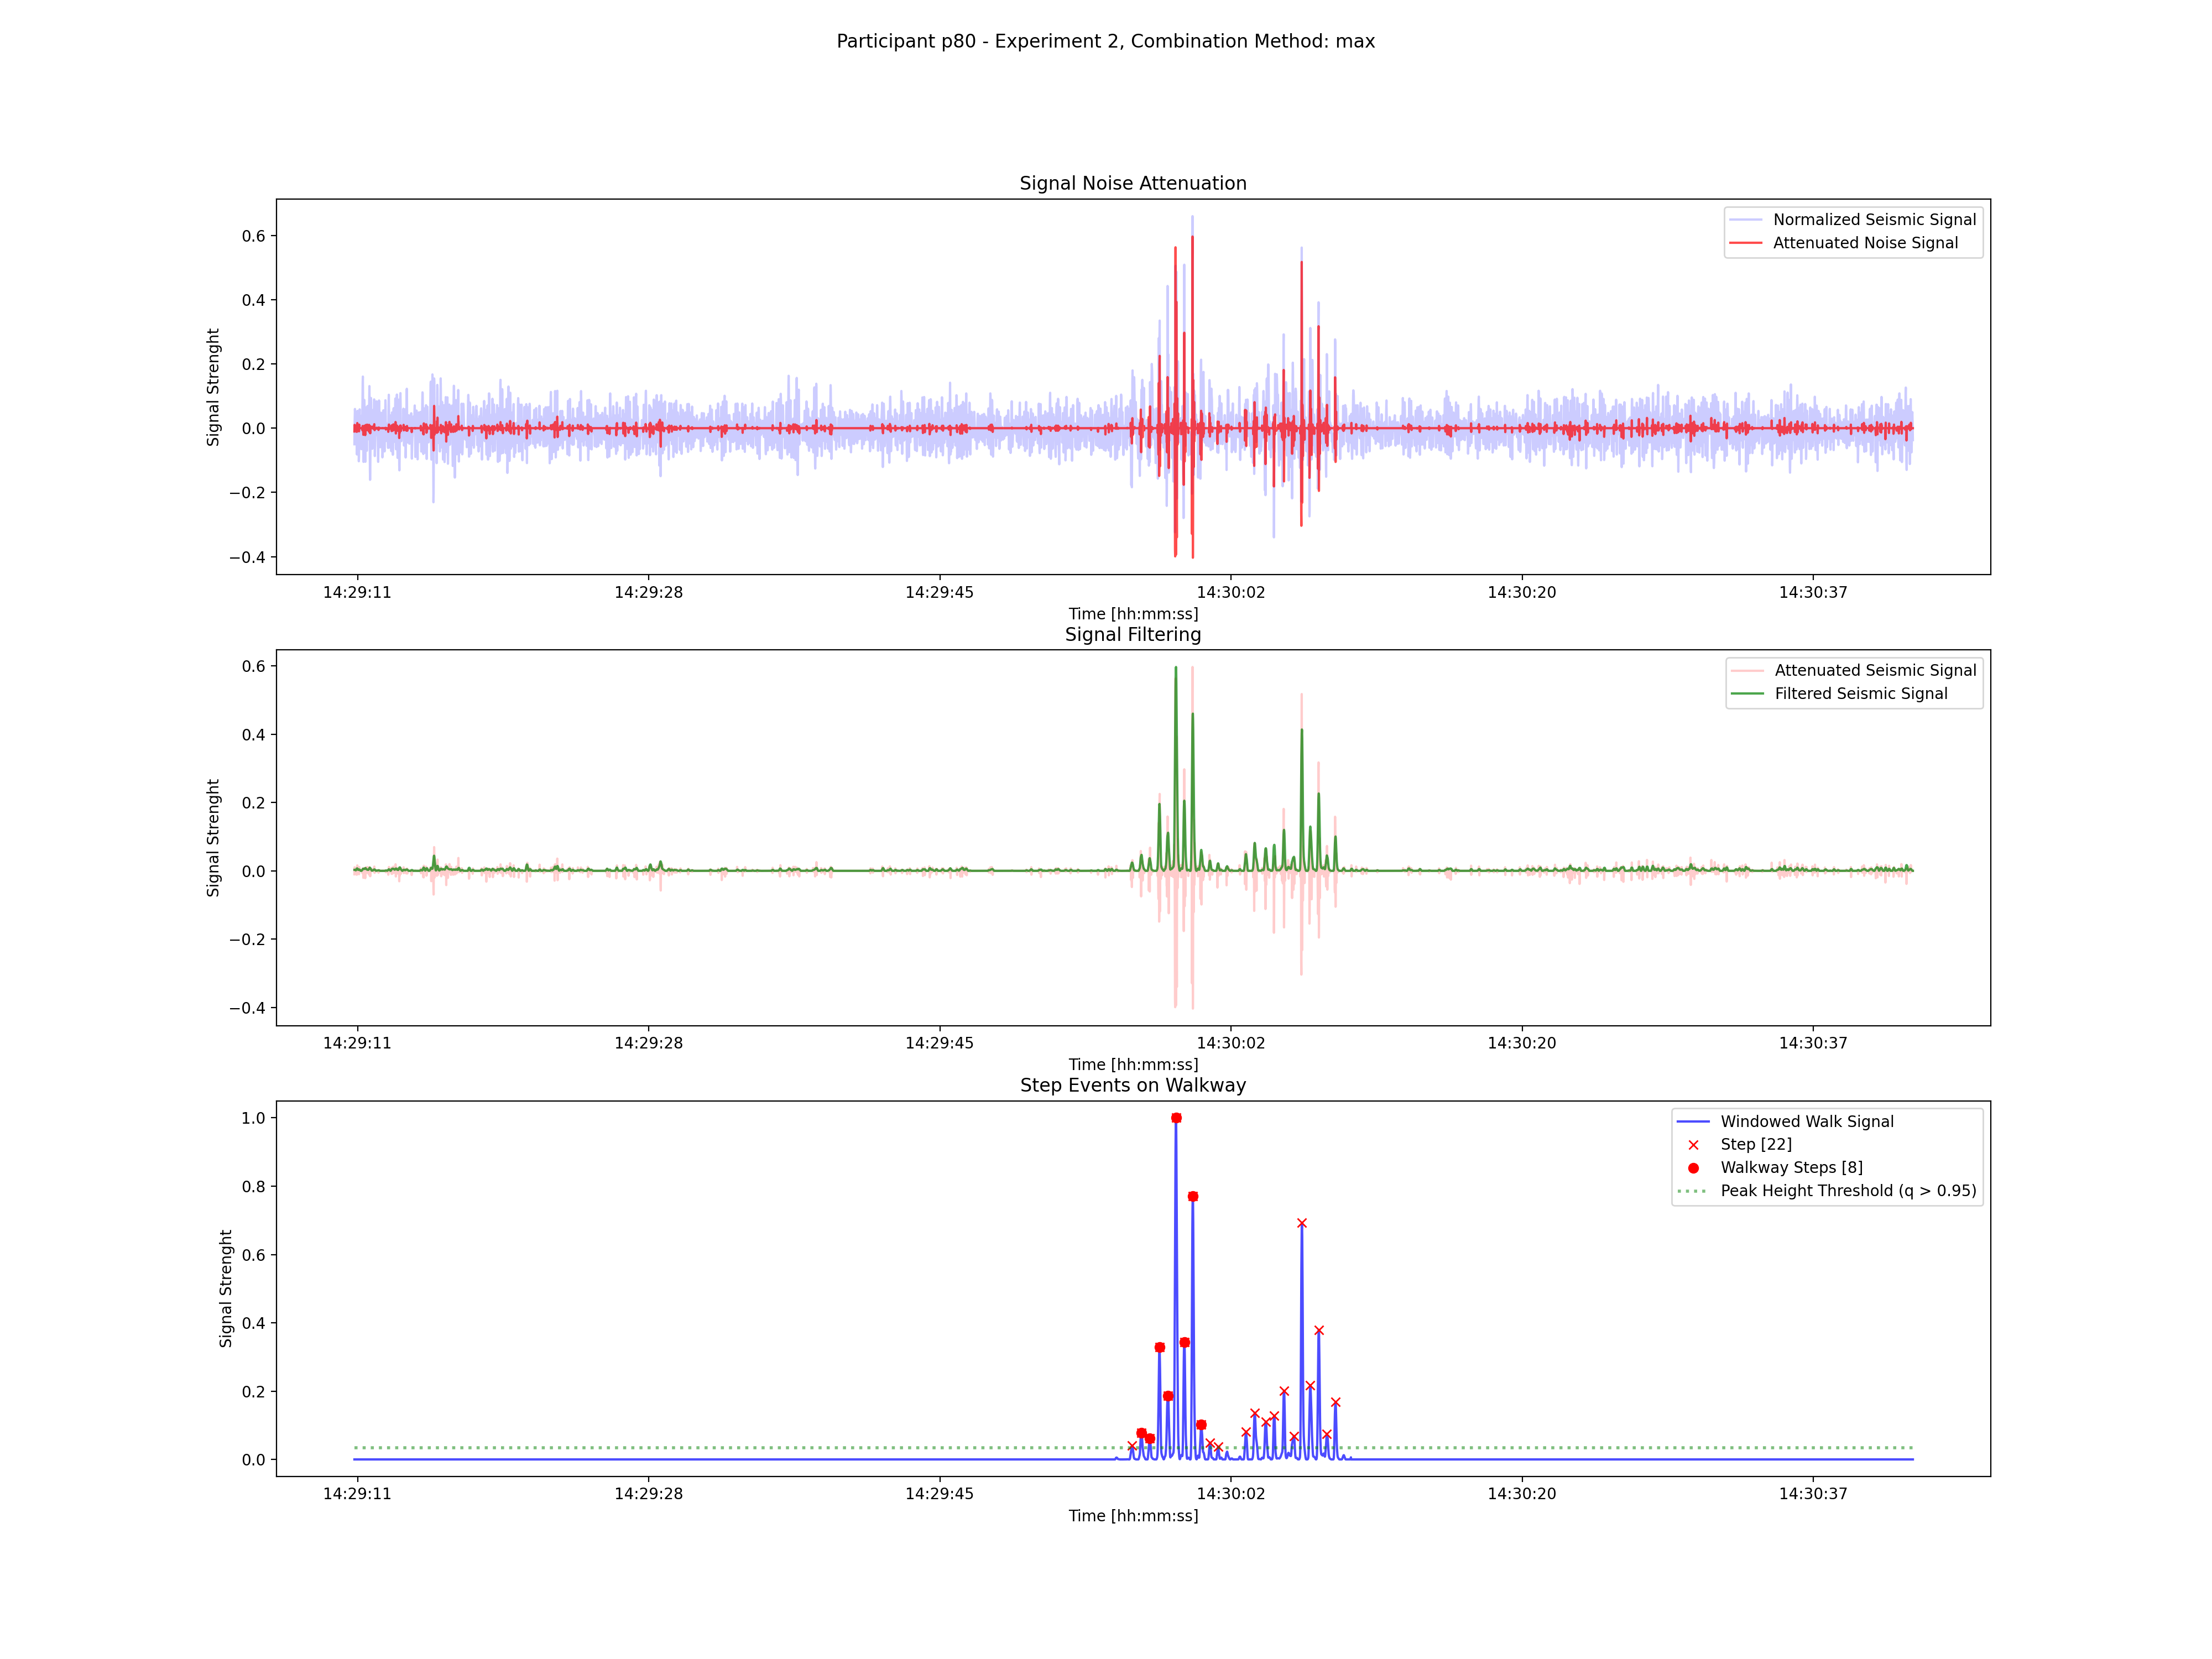

Participant p80 - Walk: 2
=>  Step Times: [480 590 510 470 490 510 500] => total: 3550.0 ms
=>  Step Time: delta=8.0ms Us=507.0ms vs GT=515ms
=>  Cycle Time: delta=0.0ms Us=1020.0ms vs GT=1020ms
=>  Ambulation Time: delta=40.0ms Us=3550.0ms vs GT=3590ms
=>  Cadence: delta=-1.3100000000000023 Us=118.31ms vs GT=117.0
=>  Velocity: delta=-5.060000000000002 cm/s Us=137.46 cm/s vs GT=132.4 cm/s
=>  Distance: delta=-0.10499999999998977 cm Us=69.71 cm vs GT=69.605 cm
Start date-time:  2021-12-01 14:29:10.856000


In [2]:
# Demo step-event extraction and gait computation on a real dataset - this participant p80 has explicitly agreed to publish its data.

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
import pandas as pd
import obspy
import os
import datetime
 

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as md

import numpy as np
import scipy as sp
from scipy import signal
import json

xfmt = md.DateFormatter('%H:%M:%S')
num_time_labels = 6

###################################
feature_name = "max"
HQ = 0.95
SE_RADIUS = 11
WALKWAY_LENGTH_CM = 488
###################################
participant_id = "p80" 
experiment_nr = 2

ranges_to_analyze = {
    "p80": {
        # from timestamp, measured by using the walkway
        # to-timestamp, measured by using the walkway
        # index-first-step-on-mat, measured by using the camera system
        # number-of-steps-on-mat, measured by using the camera system
        # avg step time in ms measured by using the walkway
        # avg cycle time [ms] measured by using the walkway
        # avg ambluation time [ms] measured by using the walkway
        # avg cycles per minute measured by using the walkway
        # avg velocity [cm / s] measured by using the walkway
        # avg distance measured by using the walkway
        "w0": ['2021-12-01 14:02:21', '2021-12-01 14:02:42', 1, 7, 670, 1345, 4020, 89.6, 116.0, 72.365],
        "w1": ['2021-12-01 14:04:59', '2021-12-01 14:05:22', 2, 8, 665, 1325, 4640, 90.5, 106.3, 67.58],
        "w2": ['2021-12-01 14:29:56', '2021-12-01 14:30:10', 2, 8, 515, 1020, 3590, 117.0, 132.4, 69.605],
        "w3": ['2021-12-01 14:31:29', '2021-12-01 14:31:45', 2, 8, 680, 1360, 4800, 87.5, 101.9, 65.275]
    }
}
range_to_analyze = ranges_to_analyze[participant_id][f"w{experiment_nr}"]

# Load the seismograph measurements
dfs = [
    pd.read_parquet(f"p{participant_id}_w{experiment_nr}_df1.parquet"),
    pd.read_parquet(f"p{participant_id}_w{experiment_nr}_df2.parquet"),
    pd.read_parquet(f"p{participant_id}_w{experiment_nr}_df3.parquet")
]

# extract features of interest by using mathematical morphologies with a spherical structural element
features = seisproc.extract_features_from_df(dfs, se_radius=SE_RADIUS, height_quantile=HQ)

# df1 denotes the combined seismigraphic signal (by using the maximum operator)
# res1 denotes the residual of the signal
# peaks1 denotes the locations of the step events
df1, res1, peaks1 = features[feature_name] 

def apply_filters(res):
    # consolidate negative and positive amplitudes
    filtered_res = np.abs(res.copy())
    
    # boos signal peaks and smooth borders
    win = signal.windows.hann(10)
    filtered_res = signal.convolve(filtered_res, win, mode='same')
    
    # smooth out double peaks
    win = signal.windows.boxcar(10)
    filtered_res = signal.convolve(filtered_res, win, mode='same')
    
    return filtered_res

filtered_res = apply_filters(res1)

normalized_data = (df1.data - np.min(df1.data)) / (np.max(df1.data) - np.min(df1.data))
normalized_res = (res1 - np.min(res1)) / (np.max(res1) - np.min(res1))

# loead region of interest in measured signal
mask1 = (df1['dt'] == df1["dt"])
start_date = pd.to_datetime(range_to_analyze[0])
end_date = pd.to_datetime(range_to_analyze[1])
mask1 = (df1['dt'] > start_date) & (df1['dt'] <= end_date)
start_peak_idx = range_to_analyze[2] - 1
end_peak_idx = start_peak_idx + (range_to_analyze[3] - 1)

HEIGHT_QUANTILE = 0.95 
PEAK_DISTANCE = 35
MIN_EXPECTED_PEAK = 0.035
MAX_XPECTED_PEAK = 0.12

# Determine step-event occurrences (identified as peaks) in seismic signals
# a) determine height of top HEIGHT_QUANTILE-percentile
# b) exclude all step-event candidates with a too low- and too high peak
height_of_top_samples = np.quantile(filtered_res * mask1, q=HEIGHT_QUANTILE)   
peak_height_scale = 1.0 / np.max(filtered_res * mask1)
height_of_top_samples = np.min([height_of_top_samples, MAX_XPECTED_PEAK / peak_height_scale])
height_of_top_samples = np.max([height_of_top_samples, MIN_EXPECTED_PEAK / peak_height_scale])
ncrespeaks, _ = sp.signal.find_peaks(filtered_res * mask1, height=height_of_top_samples, distance=PEAK_DISTANCE)
peak_indices = ncrespeaks[start_peak_idx:end_peak_idx + 1]

fig, axs = plt.subplots(3, figsize=(20, 15))
fig.suptitle(f"Participant {participant_id} - Experiment {experiment_nr}, Combination Method: {feature_name}")

row_nr = 0
axs[row_nr].set_title(f"Signal Noise Attenuation")
axs[row_nr].plot(df1.dt, normalized_data - np.mean(normalized_data), "b", alpha=0.2, label="Normalized Seismic Signal")
axs[row_nr].plot(df1.dt, normalized_res - np.mean(normalized_res), "r", alpha=0.7, label="Attenuated Noise Signal")
axs[row_nr].xaxis.set_major_formatter(xfmt)
axs[row_nr].xaxis.set_major_locator(plt.MaxNLocator(num_time_labels))
axs[row_nr].set_xlabel("Time [hh:mm:ss]")
axs[row_nr].set_ylabel("Signal Strenght")
axs[row_nr].legend()

row_nr = 1
axs[row_nr].set_title(f"Signal Filtering")
axs[row_nr].plot(df1.dt, normalized_res - np.mean(normalized_res), "r", alpha=0.2, label="Attenuated Seismic Signal")
scale = np.max(normalized_res - np.mean(normalized_res)) / np.max(filtered_res)
axs[row_nr].plot(df1.dt, scale * filtered_res, "g", alpha=0.7, label="Filtered Seismic Signal")
axs[row_nr].xaxis.set_major_formatter(xfmt)
axs[row_nr].xaxis.set_major_locator(plt.MaxNLocator(num_time_labels))
axs[row_nr].set_xlabel("Time [hh:mm:ss]")
axs[row_nr].set_ylabel("Signal Strenght")
axs[row_nr].legend()

row_nr = 2
axs[row_nr].set_title(f"Step Events on Walkway")
scale = 1.0 / np.max(filtered_res * mask1)

#INFO: IMPORTANT TO EVALUATE
amps_to_evaluate = scale * (filtered_res * mask1)[peak_indices]

axs[row_nr].plot(df1.dt, scale * filtered_res * mask1, "b", alpha=0.7, label="Windowed Walk Signal")
axs[row_nr].plot(df1.dt[ncrespeaks], scale * (filtered_res * mask1)[ncrespeaks], "x", color="red", alpha=1, label=f"Step [{len(ncrespeaks)}]")
axs[row_nr].plot(df1.dt[peak_indices], scale * (filtered_res * mask1)[peak_indices], "o", color="red", alpha=1, label=f"Walkway Steps [{len(peak_indices)}]")
axs[row_nr].xaxis.set_major_formatter(xfmt)
axs[row_nr].xaxis.set_major_locator(plt.MaxNLocator(num_time_labels))
axs[row_nr].set_xlabel("Time [hh:mm:ss]")
axs[row_nr].set_ylabel("Signal Strenght")
axs[row_nr].hlines(y=scale * height_of_top_samples, xmin=df1.dt[0], xmax=df1.dt.iloc[-1], linewidth=2, color='g', label=f"Peak Height Threshold (q > {HEIGHT_QUANTILE})", linestyles="dotted", alpha=0.5)
axs[row_nr].legend()

plt.show()
plt.savefig(f"{feature_name}_{participant_id}.png")


# Compute and report final statistics
step_times_in_ms = np.diff(df1.dt[peak_indices]) / 1_000_000
pairwise_step_times_in_ms = [(float(y), float(x)) for x, y in zip(step_times_in_ms[1:], step_times_in_ms)]



_, _, _, _, gt_ms, gt_cycle_times, gt_amb_time, gt_cadence, gt_velocity, gt_step_length = range_to_analyze

decimals_places = 2    
us_ms = np.around(float(np.mean(step_times_in_ms)), decimals=decimals_places)
us_cylce_times = np.around(np.mean(np.array([x + y for (x, y) in pairwise_step_times_in_ms])), decimals=decimals_places)
us_amb_time = np.around(float(np.sum(step_times_in_ms)), decimals=decimals_places)
us_cadence = np.around(((len(peak_indices) - 1) / float(us_amb_time)) * 1000.0 * 60, decimals=decimals_places)
us_velocity = np.around(WALKWAY_LENGTH_CM / (us_amb_time * 0.001), decimals=decimals_places)

step_times_in_seconds = np.array([float(step_time_) / 1000.0  for step_time_ in step_times_in_ms])
step_lengths = step_times_in_seconds * us_velocity
us_step_length = np.around(np.mean(step_lengths), decimals=decimals_places)

total_walk_time = np.sum(step_times_in_ms)
print(f"Participant {participant_id} - Walk: {experiment_nr}")
print(f"=>  Step Times: {step_times_in_ms} => total: {float(total_walk_time)} ms")
print(f"=>  Step Time: delta={gt_ms - us_ms}ms Us={np.around(us_ms, decimals=decimals_places) }ms vs GT={gt_ms}ms")
print(f"=>  Cycle Time: delta={gt_cycle_times - us_cylce_times}ms Us={np.around(us_cylce_times, decimals=decimals_places) }ms vs GT={gt_cycle_times}ms")
print(f"=>  Ambulation Time: delta={gt_amb_time - us_amb_time}ms Us={np.around(us_amb_time, decimals=decimals_places) }ms vs GT={gt_amb_time}ms")
print(f"=>  Cadence: delta={gt_cadence - us_cadence} Us={np.around(us_cadence, decimals=decimals_places) }ms vs GT={gt_cadence}")
print(f"=>  Velocity: delta={gt_velocity - us_velocity} cm/s Us={np.around(us_velocity, decimals=decimals_places) } cm/s vs GT={gt_velocity} cm/s")
print(f"=>  Distance: delta={gt_step_length - us_step_length} cm Us={np.around(us_step_length, decimals=decimals_places) } cm vs GT={gt_step_length} cm")
print("Start date-time: ", df1.dt[0])

<IPython.core.display.Javascript object>


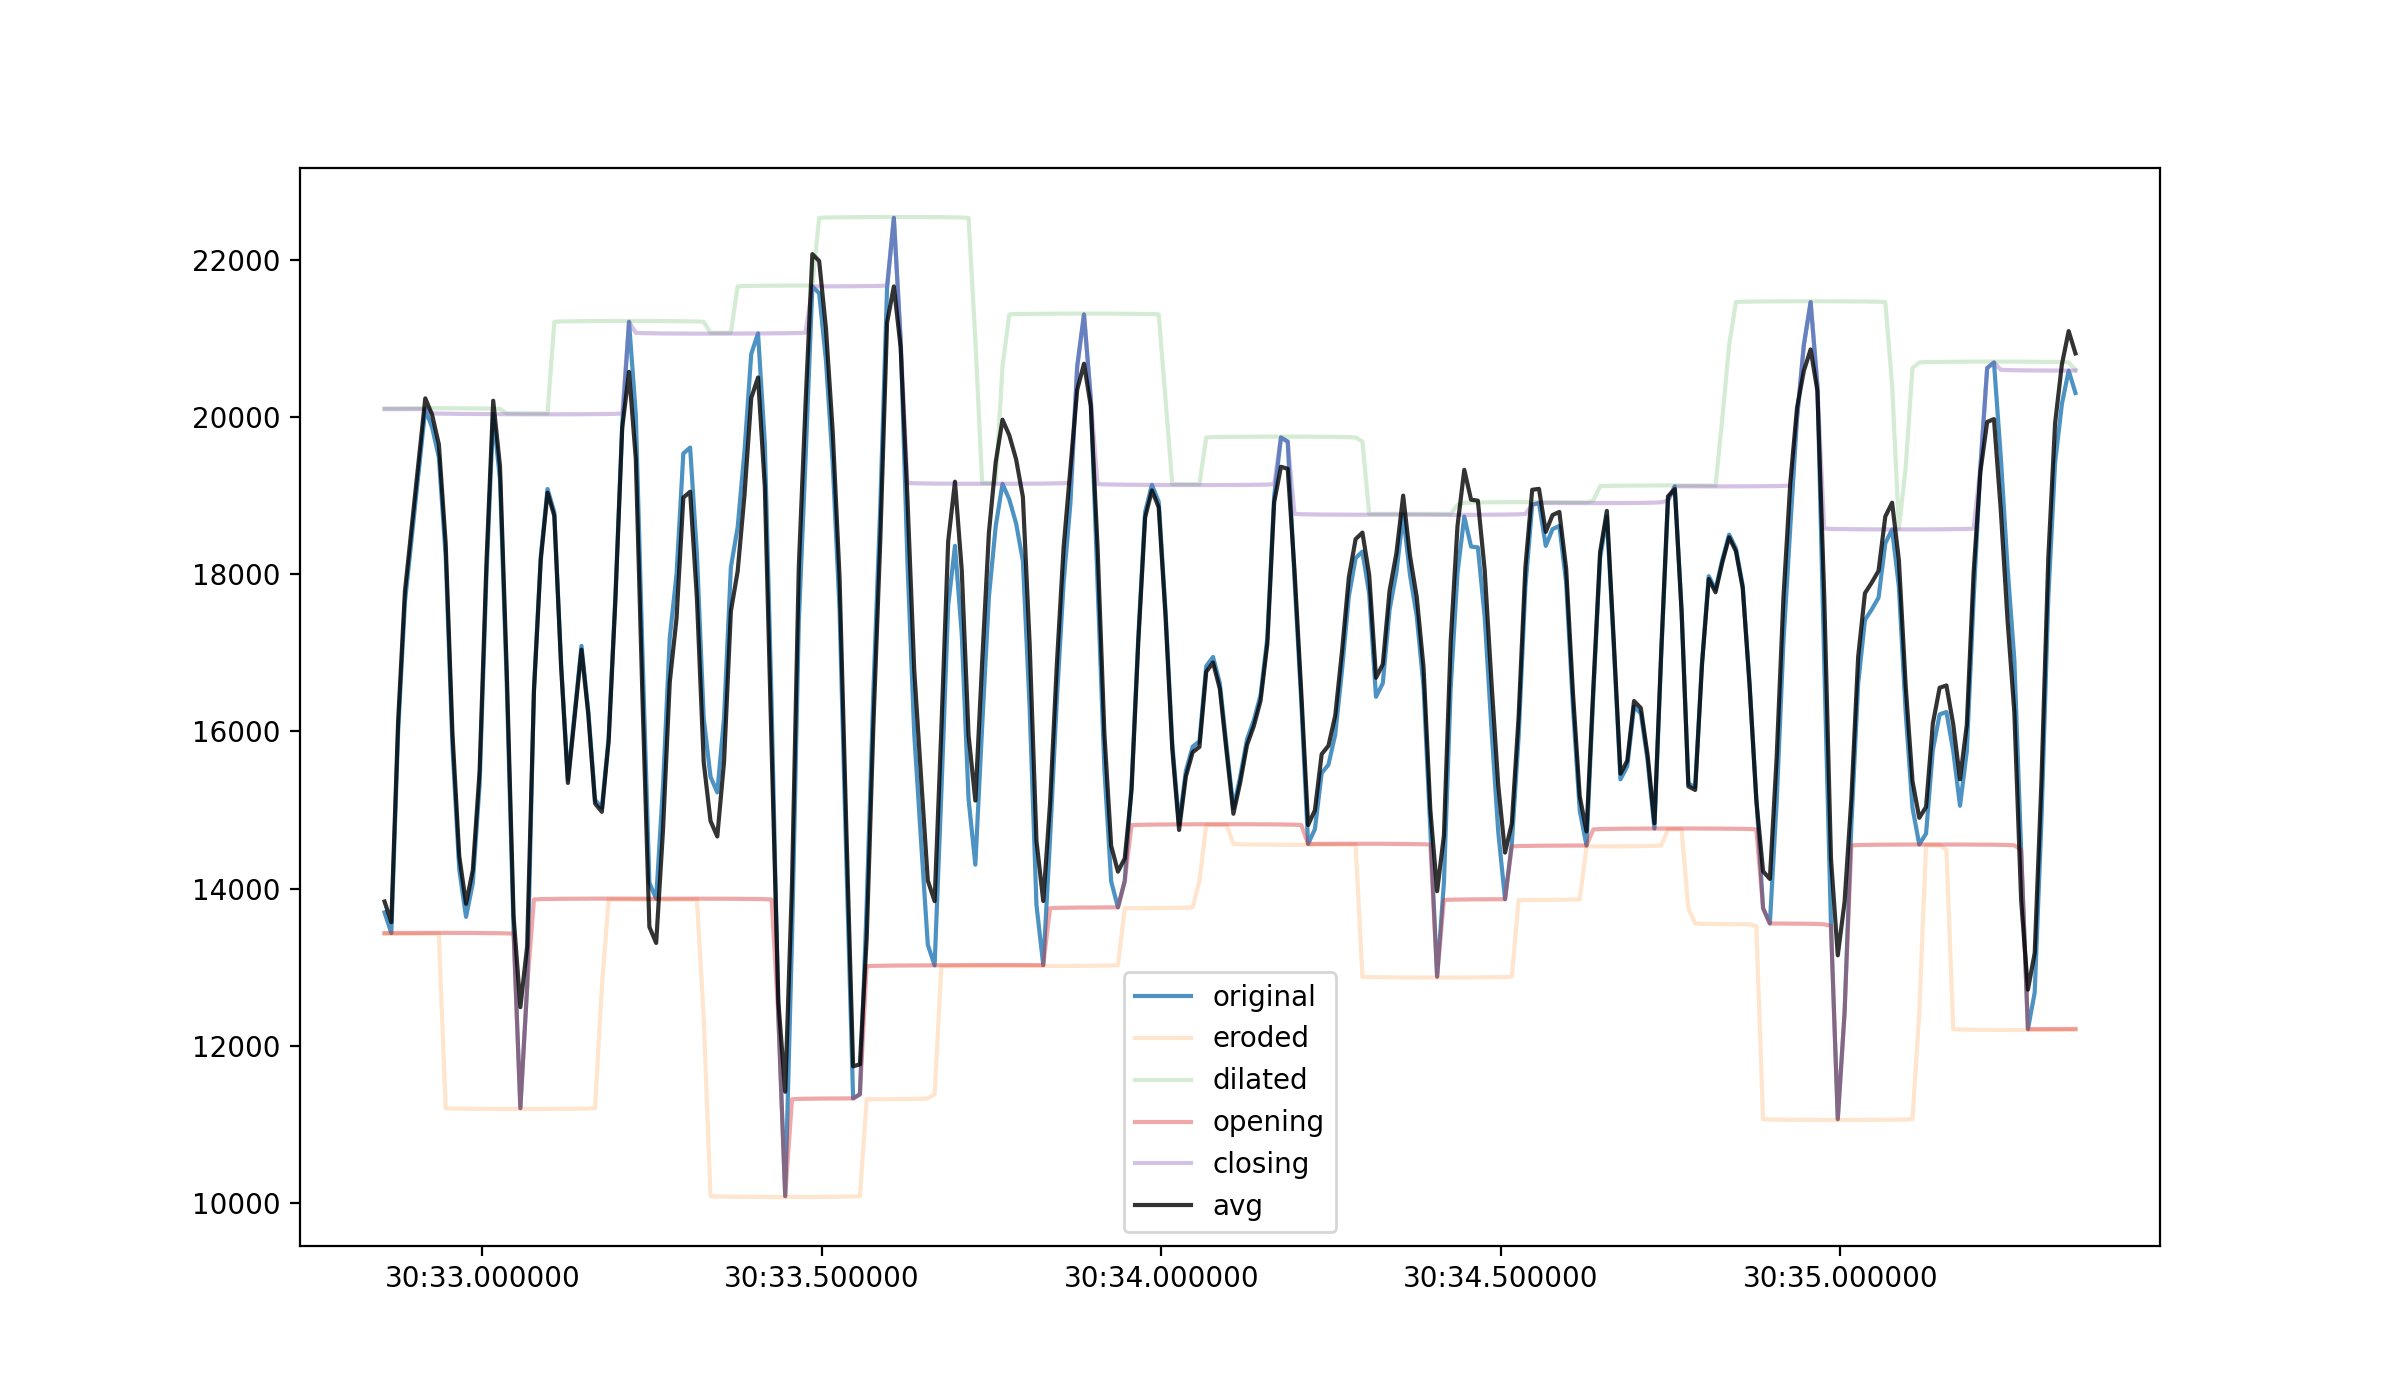

<IPython.core.display.Javascript object>


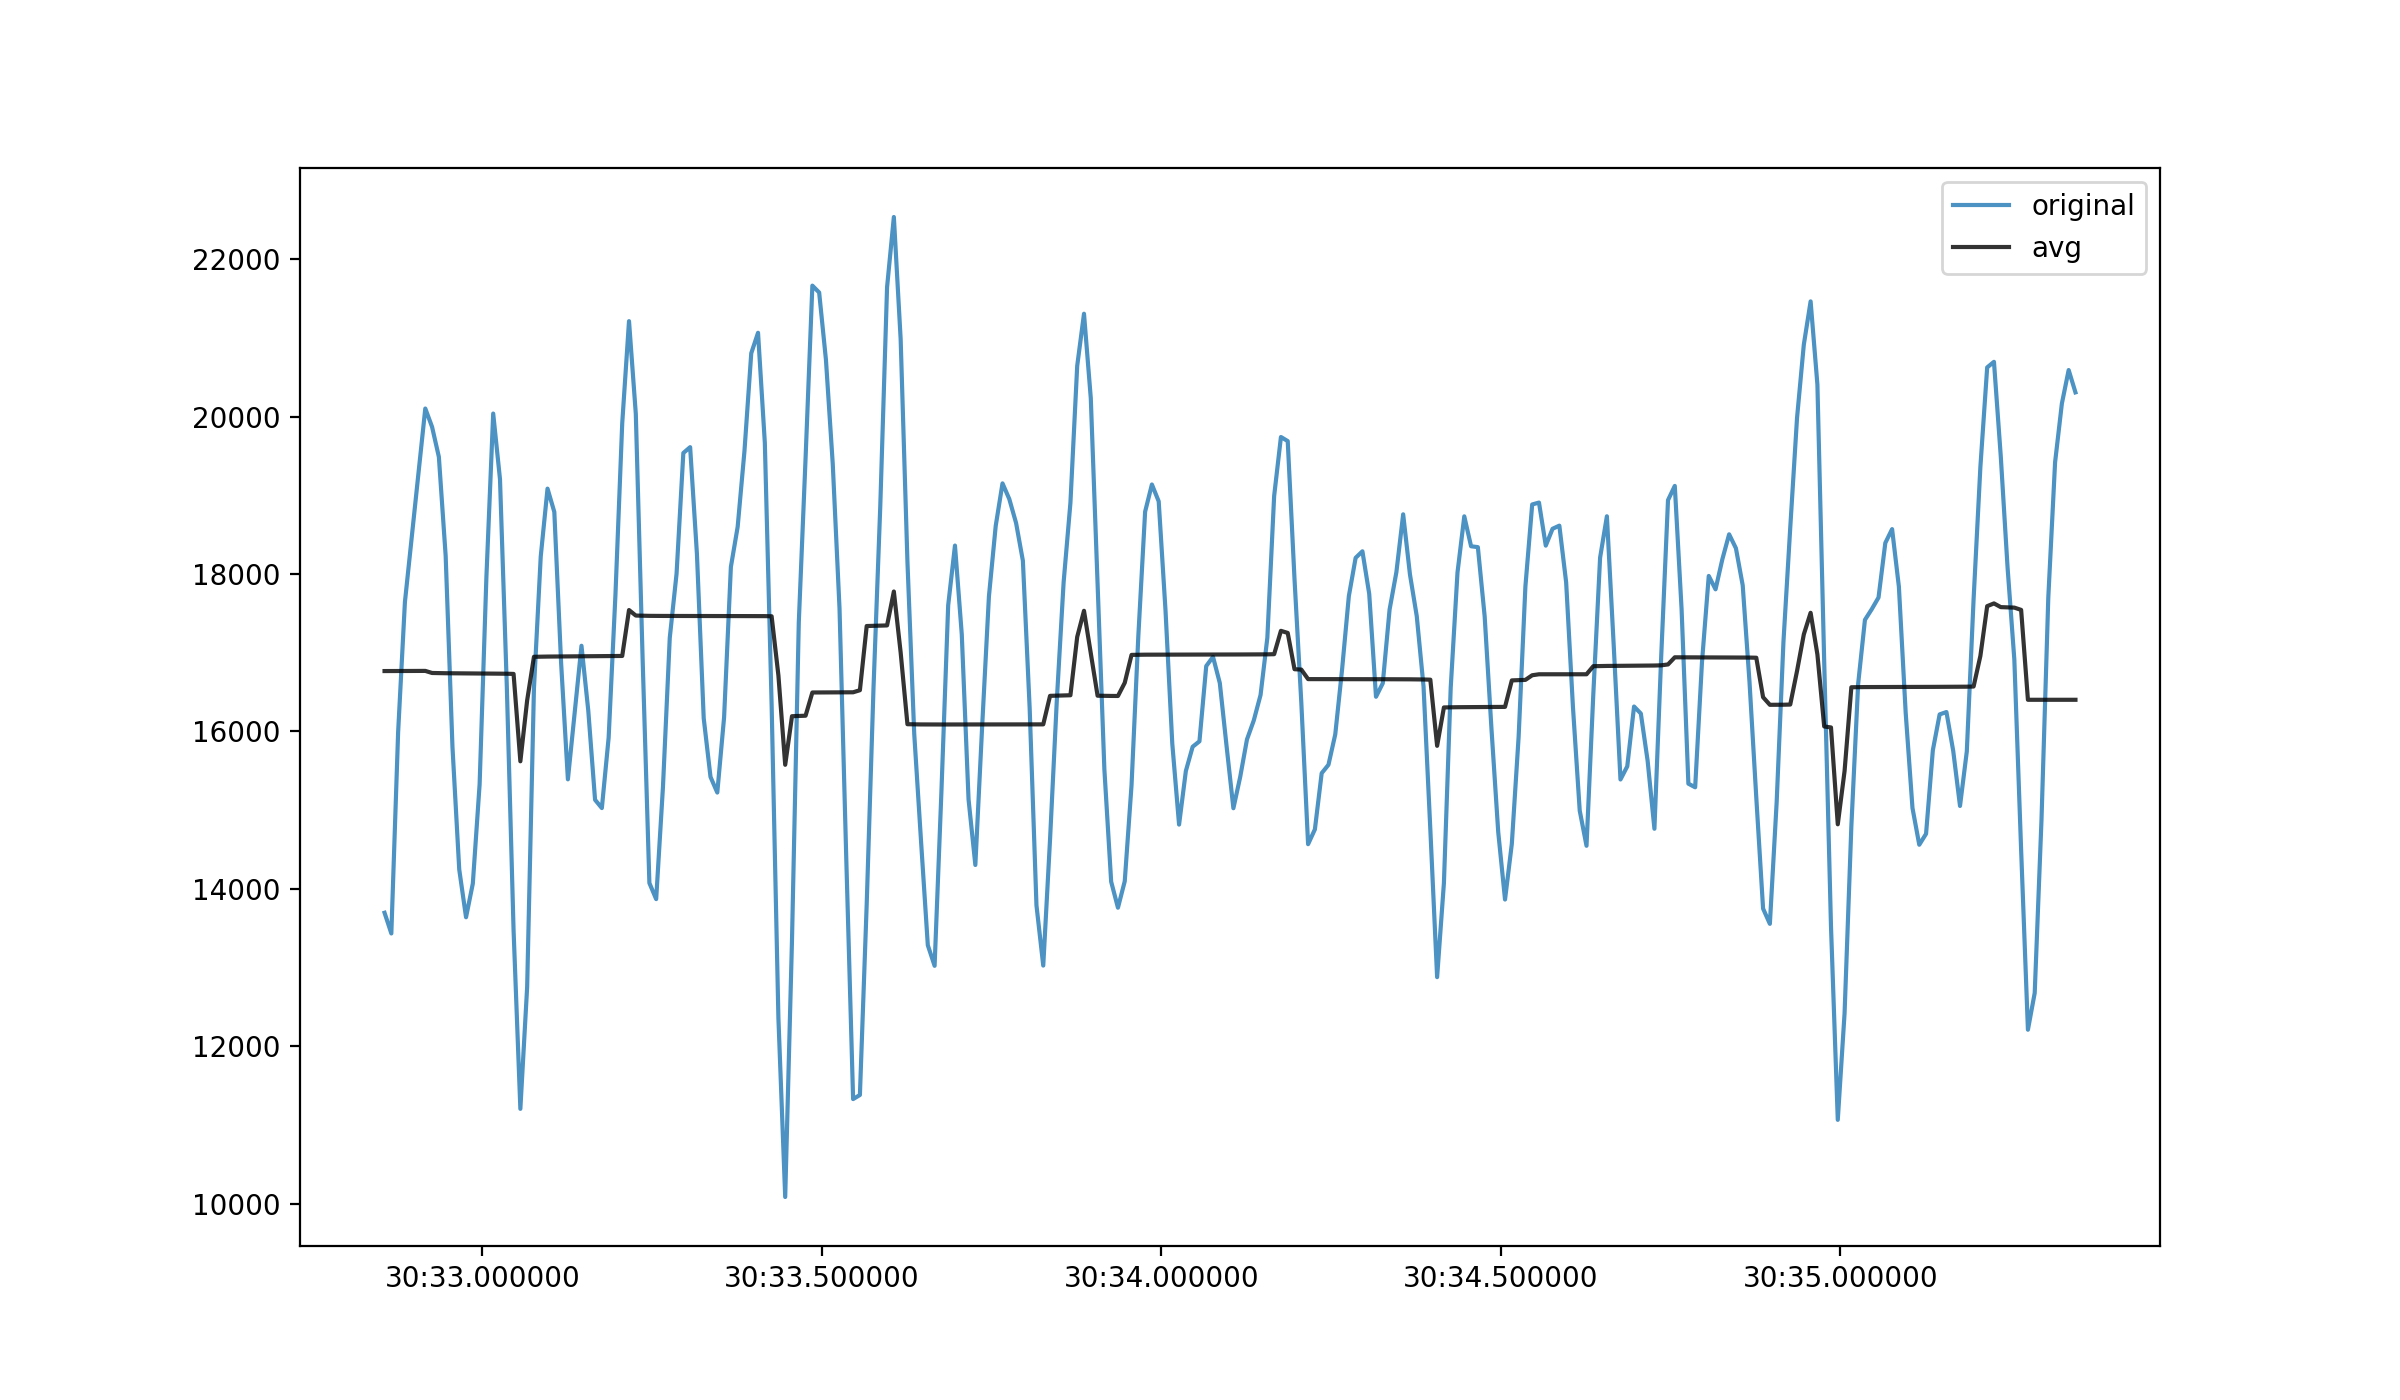

<IPython.core.display.Javascript object>


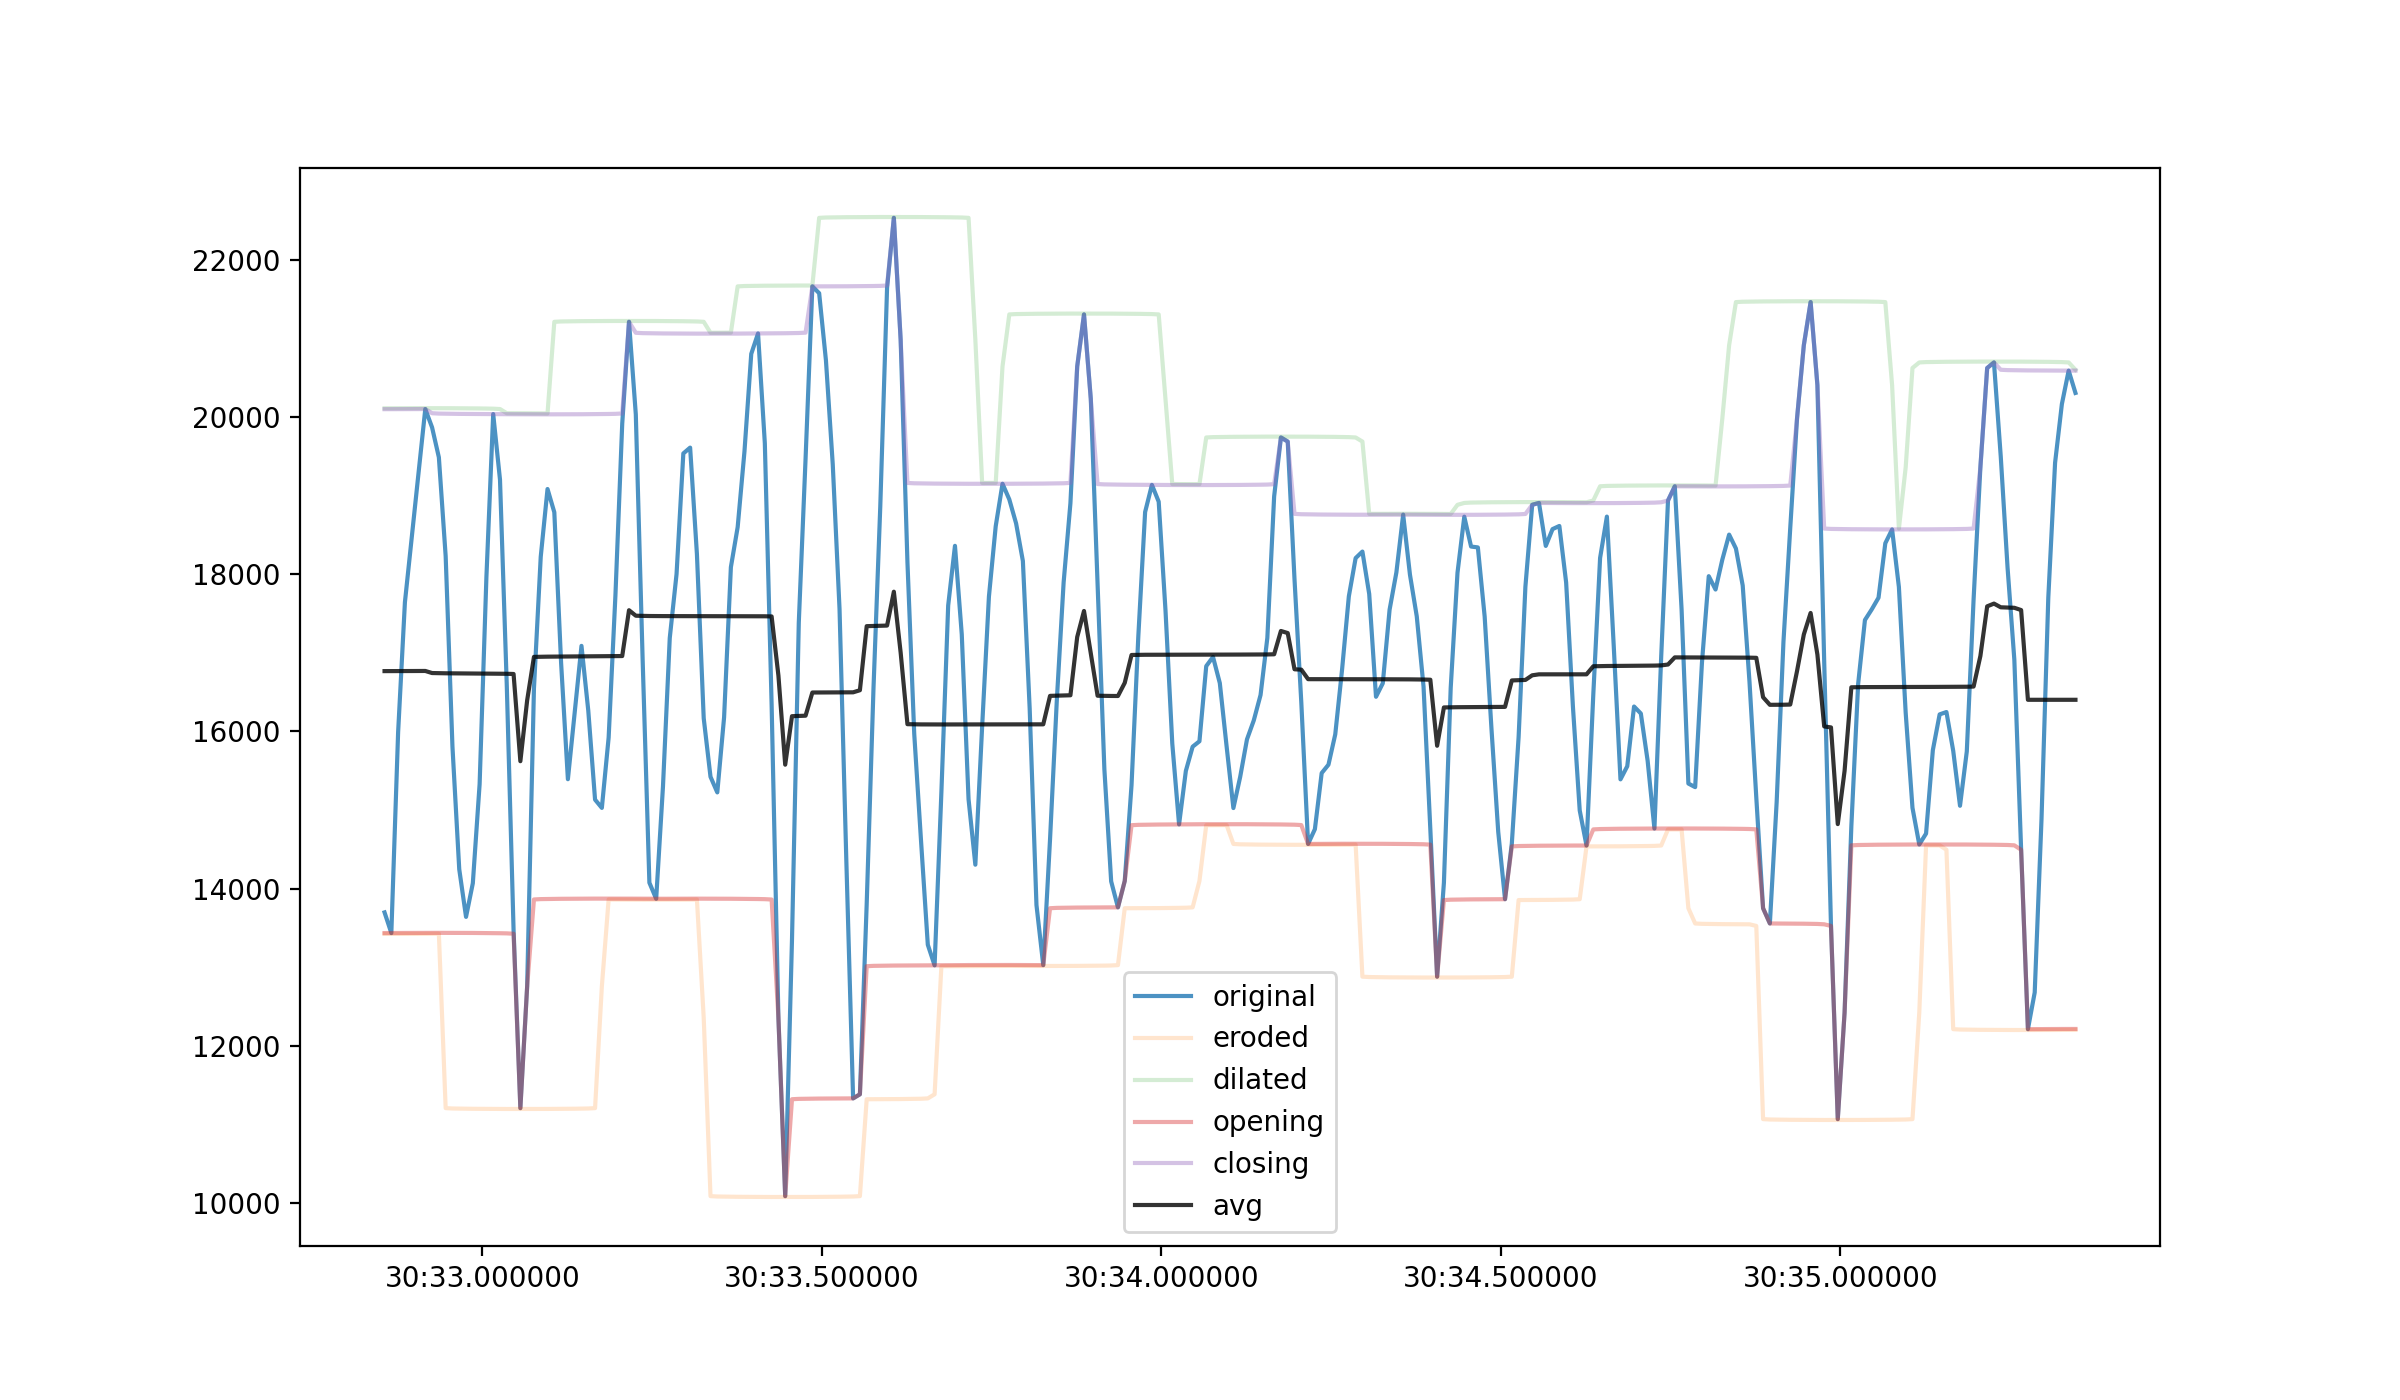

<IPython.core.display.Javascript object>


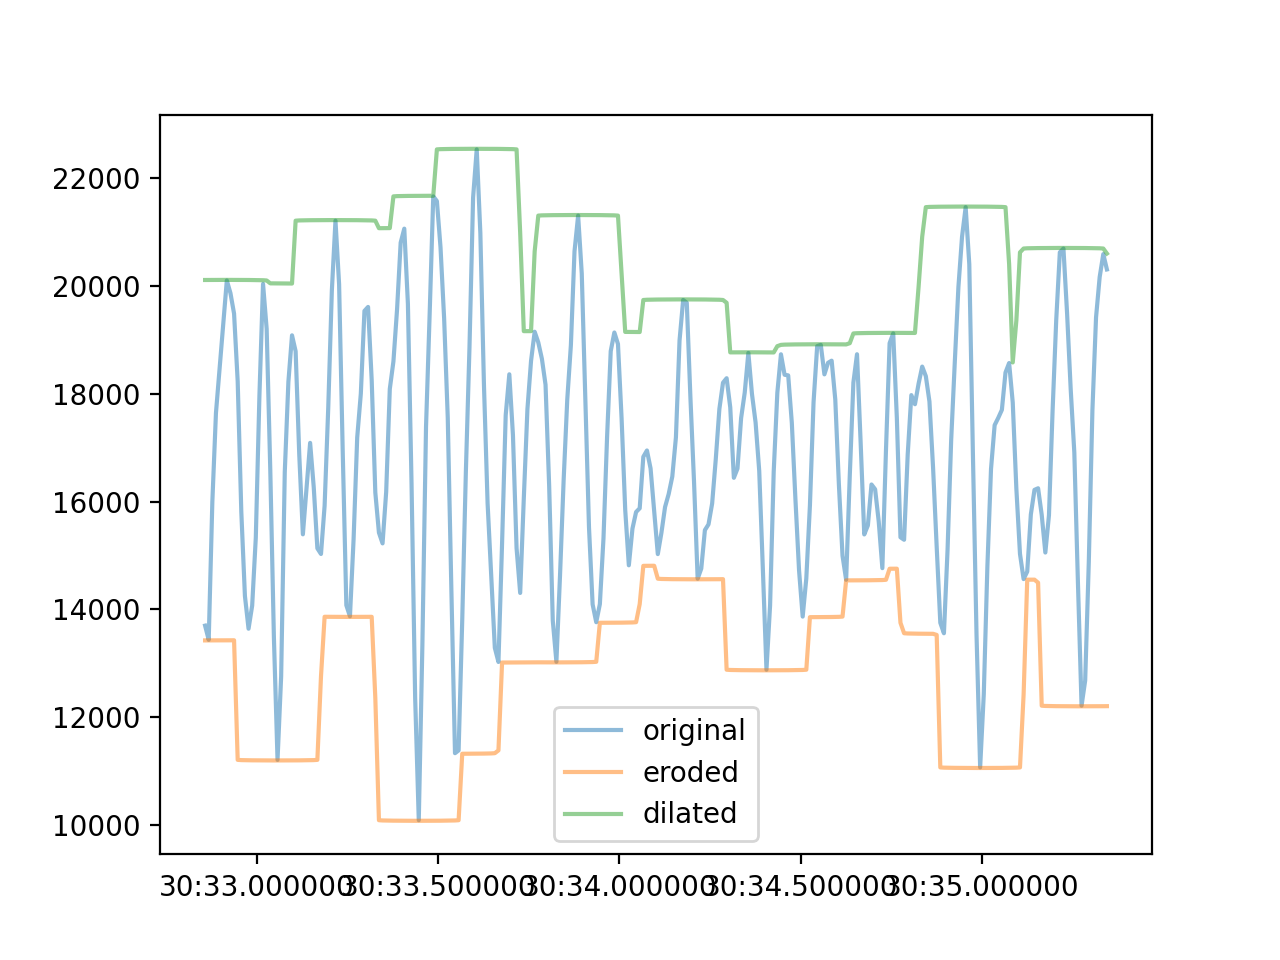

<IPython.core.display.Javascript object>


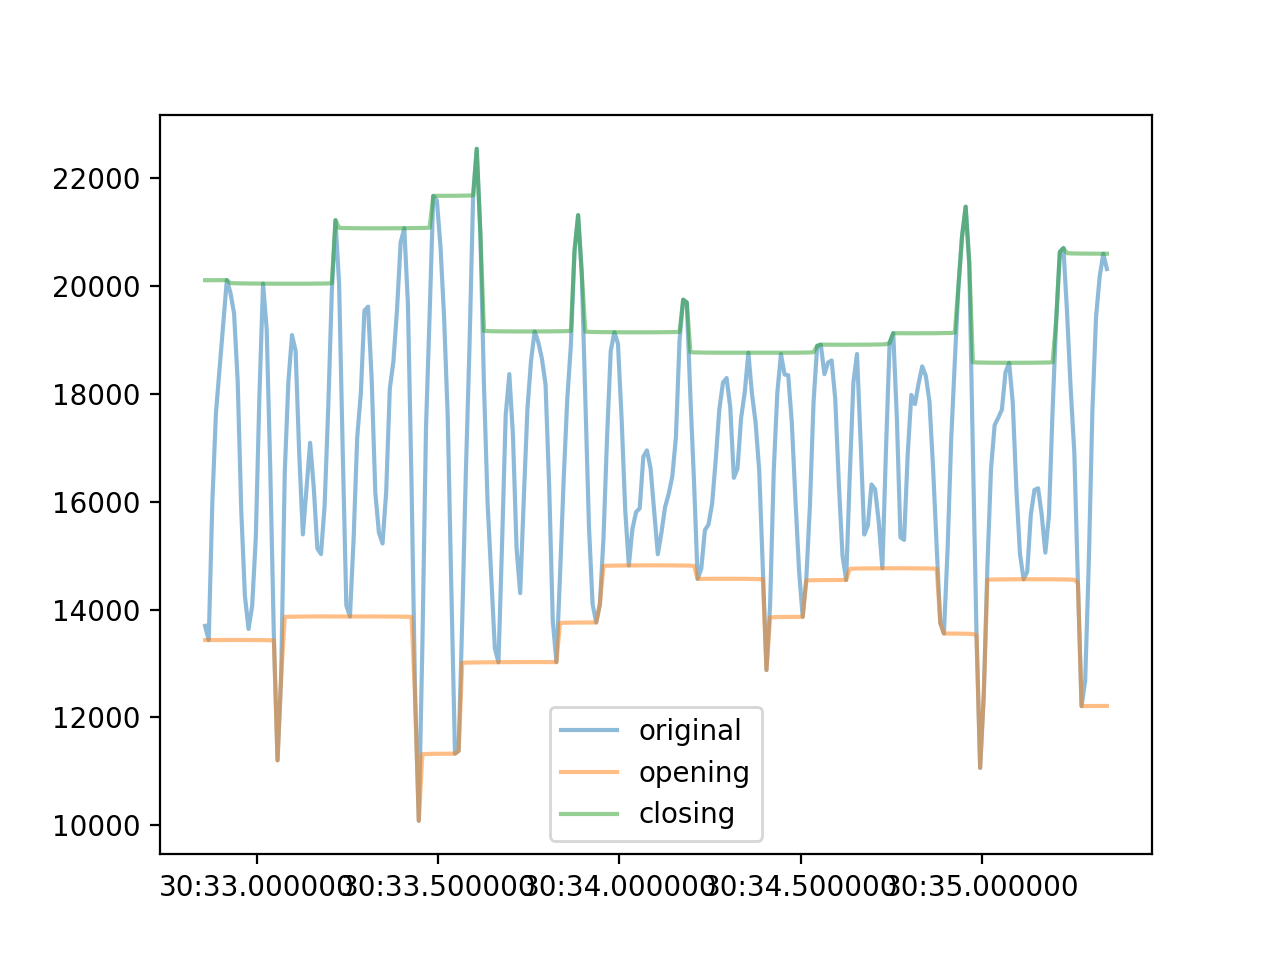

<IPython.core.display.Javascript object>


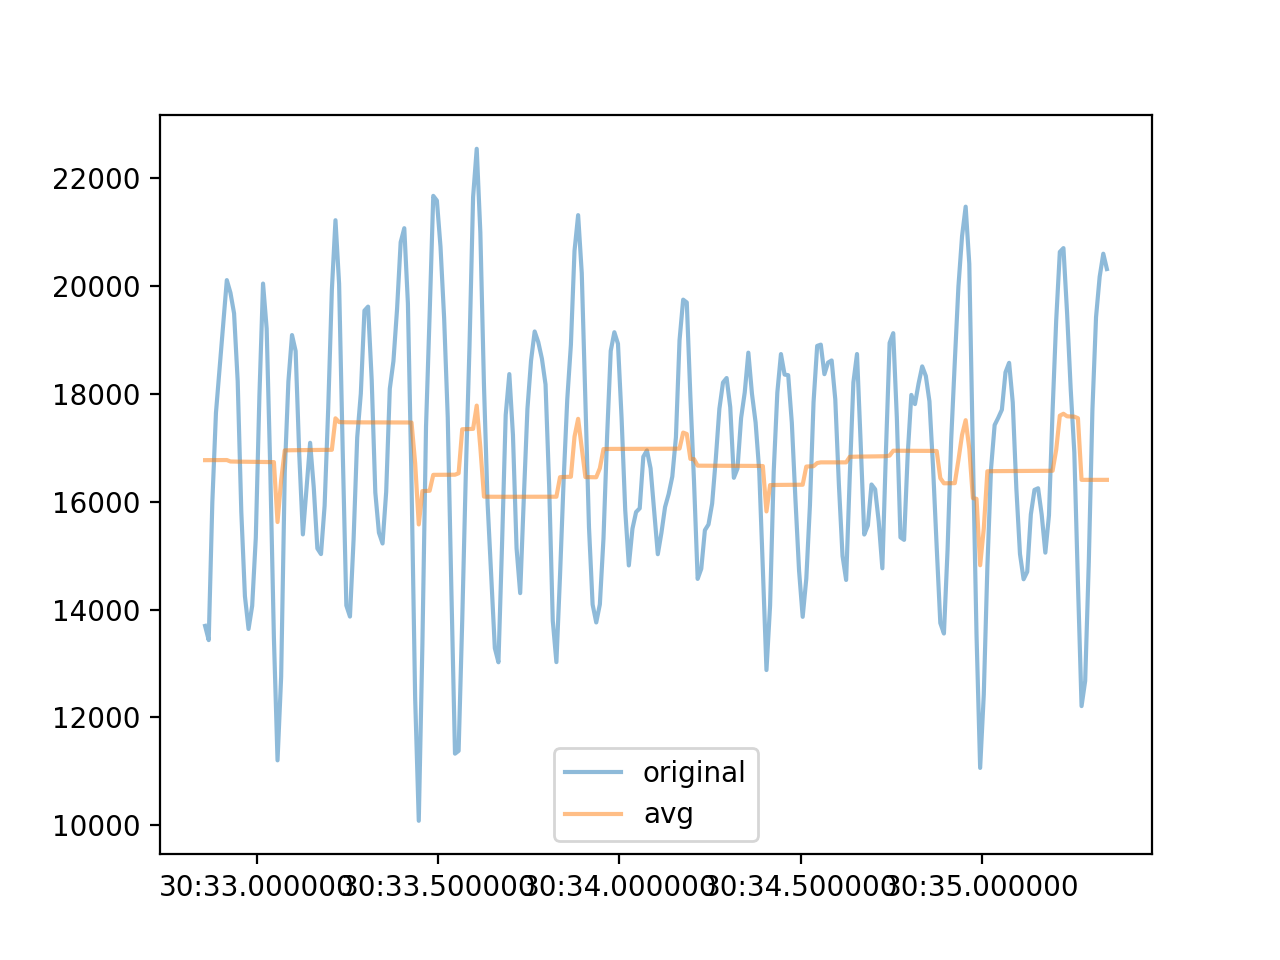

In [3]:
start_idx = 8200
end_idx = 8450

s_dt = df1.iloc[start_idx:end_idx].dt
s_data = df1.iloc[start_idx:end_idx].data

data = np.array(s_data)
#data = (data - np.mean(data)) / (np.max(data) - np.min(data))  # * 10_000



se = seisproc.structural_element(radius=11)
#plt.plot(df1.iloc[start_idx:end_idx].dt, df1.iloc[start_idx:end_idx].data)

s_data_eroded = seisproc.erosion(data, se)
s_data_dilated = seisproc.dilation(data, se)
s_data_opening = seisproc.opening(data, se)
s_data_closing = seisproc.closing(data, se)
ctf = data - 0.5*(s_data_opening + s_data_closing)
baseline = np.mean(data)

plt.figure(figsize=(12, 7))
plt.plot(s_dt, data, alpha=0.8, label="original")
plt.plot(s_dt, s_data_eroded, alpha=0.2, label="eroded")
plt.plot(s_dt, s_data_dilated, alpha=0.2, label="dilated")
plt.plot(s_dt, s_data_opening, alpha=0.4, label="opening")
plt.plot(s_dt, s_data_closing, alpha=0.4, label="closing")
plt.plot(s_dt, baseline + ctf, color="black", alpha=0.8, label="avg")
plt.legend()
plt.show()



plt.figure(figsize=(12, 7))
plt.plot(s_dt, data, alpha=0.8, label="original")
plt.plot(s_dt, 0.5*(s_data_opening + s_data_closing), color="black", alpha=0.8, label="avg")
plt.legend()



se = seisproc.structural_element(radius=11)

s_data_eroded = seisproc.erosion(data, se)
s_data_dilated = seisproc.dilation(data, se)
s_data_opening = seisproc.opening(data, se)
s_data_closing = seisproc.closing(data, se)

plt.figure(figsize=(12, 7))
plt.plot(s_dt, data, alpha=0.8, label="original")
plt.plot(s_dt, s_data_eroded, alpha=0.2, label="eroded")
plt.plot(s_dt, s_data_dilated, alpha=0.2, label="dilated")
plt.plot(s_dt, s_data_opening, alpha=0.4, label="opening")
plt.plot(s_dt, s_data_closing, alpha=0.4, label="closing")
plt.plot(s_dt, 0.5*(s_data_opening + s_data_closing), color="black", alpha=0.8, label="avg")
plt.legend()


plt.figure()
plt.plot(s_dt, data, alpha=0.5, label="original")
plt.plot(s_dt, s_data_eroded, alpha=0.5, label="eroded")
plt.plot(s_dt, s_data_dilated, alpha=0.5, label="dilated")
plt.legend()

plt.figure()
plt.plot(s_dt, data, alpha=0.5, label="original")
plt.plot(s_dt, s_data_opening, alpha=0.5, label="opening")
plt.plot(s_dt, s_data_closing, alpha=0.5, label="closing")
plt.legend()

plt.figure()
plt.plot(s_dt, data, alpha=0.5, label="original")
plt.plot(s_dt, 0.5*(s_data_opening + s_data_closing), alpha=0.5, label="avg")
plt.legend()


In [4]:
# Load the gait parrameters from the conducted experiments and regenerate the results in the paper 

In [5]:
import pandas as pd
statistic_df = pd.read_csv("statistics.csv")

import matplotlib.pyplot as plt
from scipy.stats import linregress
import scipy.stats
from scipy import stats
from scipy.stats import pearsonr
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score
from scipy.stats import f_oneway


def abline(axes, slope, intercept):
    """Plot a line from slope and intercept"""
    #axes = ax.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    axes.plot(x_vals, y_vals, '--')
    
import numpy as np
import scipy.stats
  
import statsmodels.api as sm
from sklearn.metrics import fbeta_score




# The exact way that these degrees of freedom are calculated depends on the statistical test you are using. Standard textbooks will describe these approaches. For example, in a standard one-way between subjects ANOVA with k
# groups and n
# participants per group, you would have k−1
# numerator degrees of freedom and kn−k
def f_test(group1, group2):
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = group1.size-1
    dun = group2.size-1
    p_value = 1-scipy.stats.f.cdf(f, nun, dun)


    
    return f, p_value
  
def perform_regression_statistics(ax, a, b, title):
    print(f"Regression results for: {title}")
    print("N = ", len(a))
    
    print("deg. freedom: ", len(a) * 2 - 2)
    # P-value evaluates how well your data rejects the null hypothesis, which states that there is no relationship between two compared groups.
    #a = us_mss
    #b = gt_mss
    #b = np.random.rand(10)

    # Reject the null hypothesis when the p-value is less than or equal to your significance level

    # alternative HA ‘two-sided’: the correlation is nonzero
    result = scipy.stats.pearsonr(a, b)
    print(result)
    print("C95%: ", result.confidence_interval())


    regres = linregress(a, b)
    print(regres)
    print("R2: ", r2_score(a, b))
    # perform F-test
    f, p_value = f_test(a,b)
    print(f"F(1, {len(a) * 2 - 2}) = {f} p = {p_value}")
    
    F_anova_one_way, p_anova_one_way = f_oneway(a, b)
    print(f"ANOVA one way: F={F_anova_one_way} p={p_anova_one_way}")
    
    #print("Beta scores:\n", fbeta_score(b, a, average='macro', beta=0.5))
    #print("P scores:\n", precision_score(b, a, average='macro'))
    
    
    A = sm.add_constant(a)
    mod = sm.OLS(b, A)
    res = mod.fit()
    
    print()
    print(res.summary())
    
    #plt.figure(f"Correlation {title}")
    ax.set_title(title)
    ax.scatter(a, b)
    ax.set_xlabel("Seismograph")
    ax.set_ylabel("Walkway")
    abline(ax, regres.slope, regres.intercept)
    x = np.array(range(len(a)))



    #plt.legend()
    #plt.show()

<IPython.core.display.Javascript object>


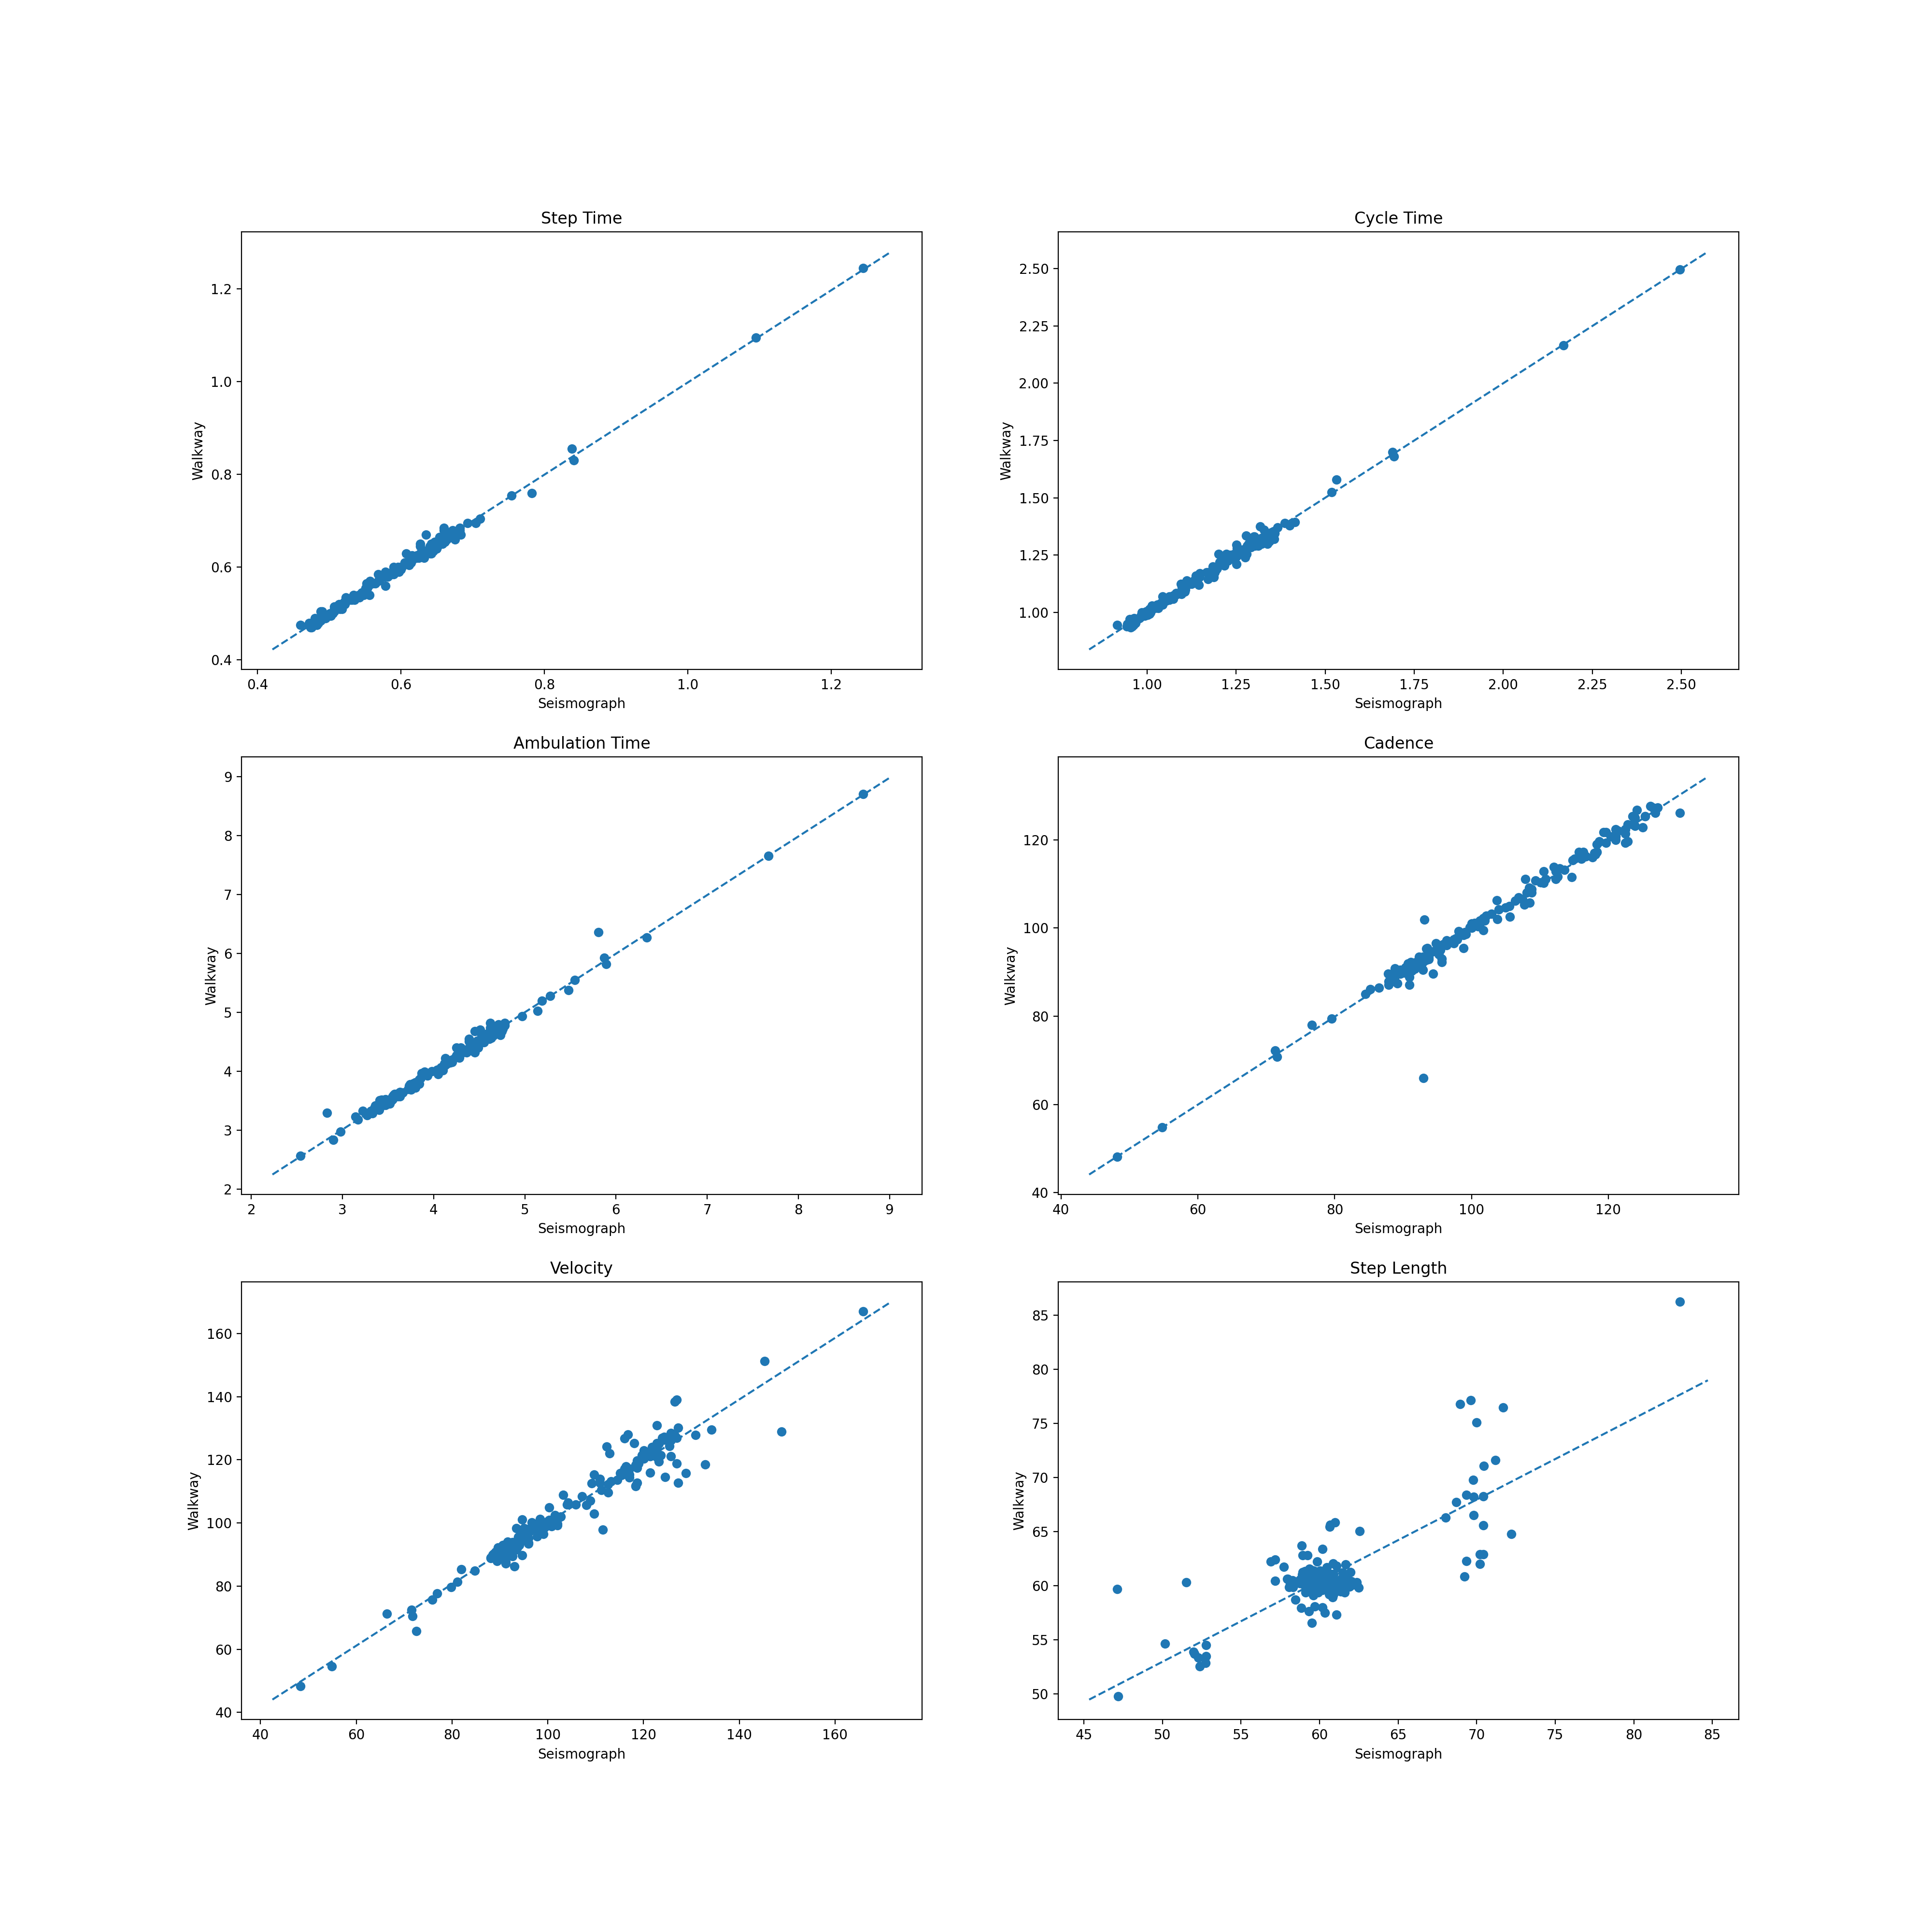

Regression results for: Step Time
N =  200
deg. freedom:  398
PearsonRResult(statistic=0.9968318597944632, pvalue=1.1691400036000193e-219)
C95%:  ConfidenceInterval(low=0.9958132791873184, high=0.9976029291862998)
LinregressResult(slope=0.9942041039359466, intercept=0.004321229403238536, rvalue=0.996831859794463, pvalue=1.1691400036080668e-219, stderr=0.005637596533884476, intercept_stderr=0.0034404329978640776)
R2:  0.9935938132633434
F(1, 398) = 1.005293135535861 p = 0.48516707447248386
ANOVA one way: F=0.007947129590788365 p=0.9290101852055921

                            OLS Regression Results                            
Dep. Variable:           gt_step_time   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 3.110e+04
Date:                Tue, 05 Sep 2023   Prob (F-statistic):          1.17e-219
Time:                        22:42:39   Log-Likelih

In [6]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

perform_regression_statistics(axs[0][0], b=statistic_df.gt_step_time / 1000.0, a=statistic_df.us_step_time / 1000.0, title="Step Time")
perform_regression_statistics(axs[0][1], b=statistic_df.gt_cycle_time / 1000.0, a=statistic_df.us_cycle_time / 1000.0, title="Cycle Time")
perform_regression_statistics(axs[1][0], b=statistic_df.gt_ambulation_time / 1000.0, a=statistic_df.us_ambulation_time / 1000.0, title="Ambulation Time")
perform_regression_statistics(axs[1][1], b=statistic_df.gt_cadence, a=statistic_df.us_cadence, title="Cadence")
perform_regression_statistics(axs[2][0], b=statistic_df.gt_velocity, a=statistic_df.us_velocity, title="Velocity")
perform_regression_statistics(axs[2][1], b=statistic_df.gt_step_length, a=statistic_df.us_step_length, title="Step Length")

plt.show()

<IPython.core.display.Javascript object>


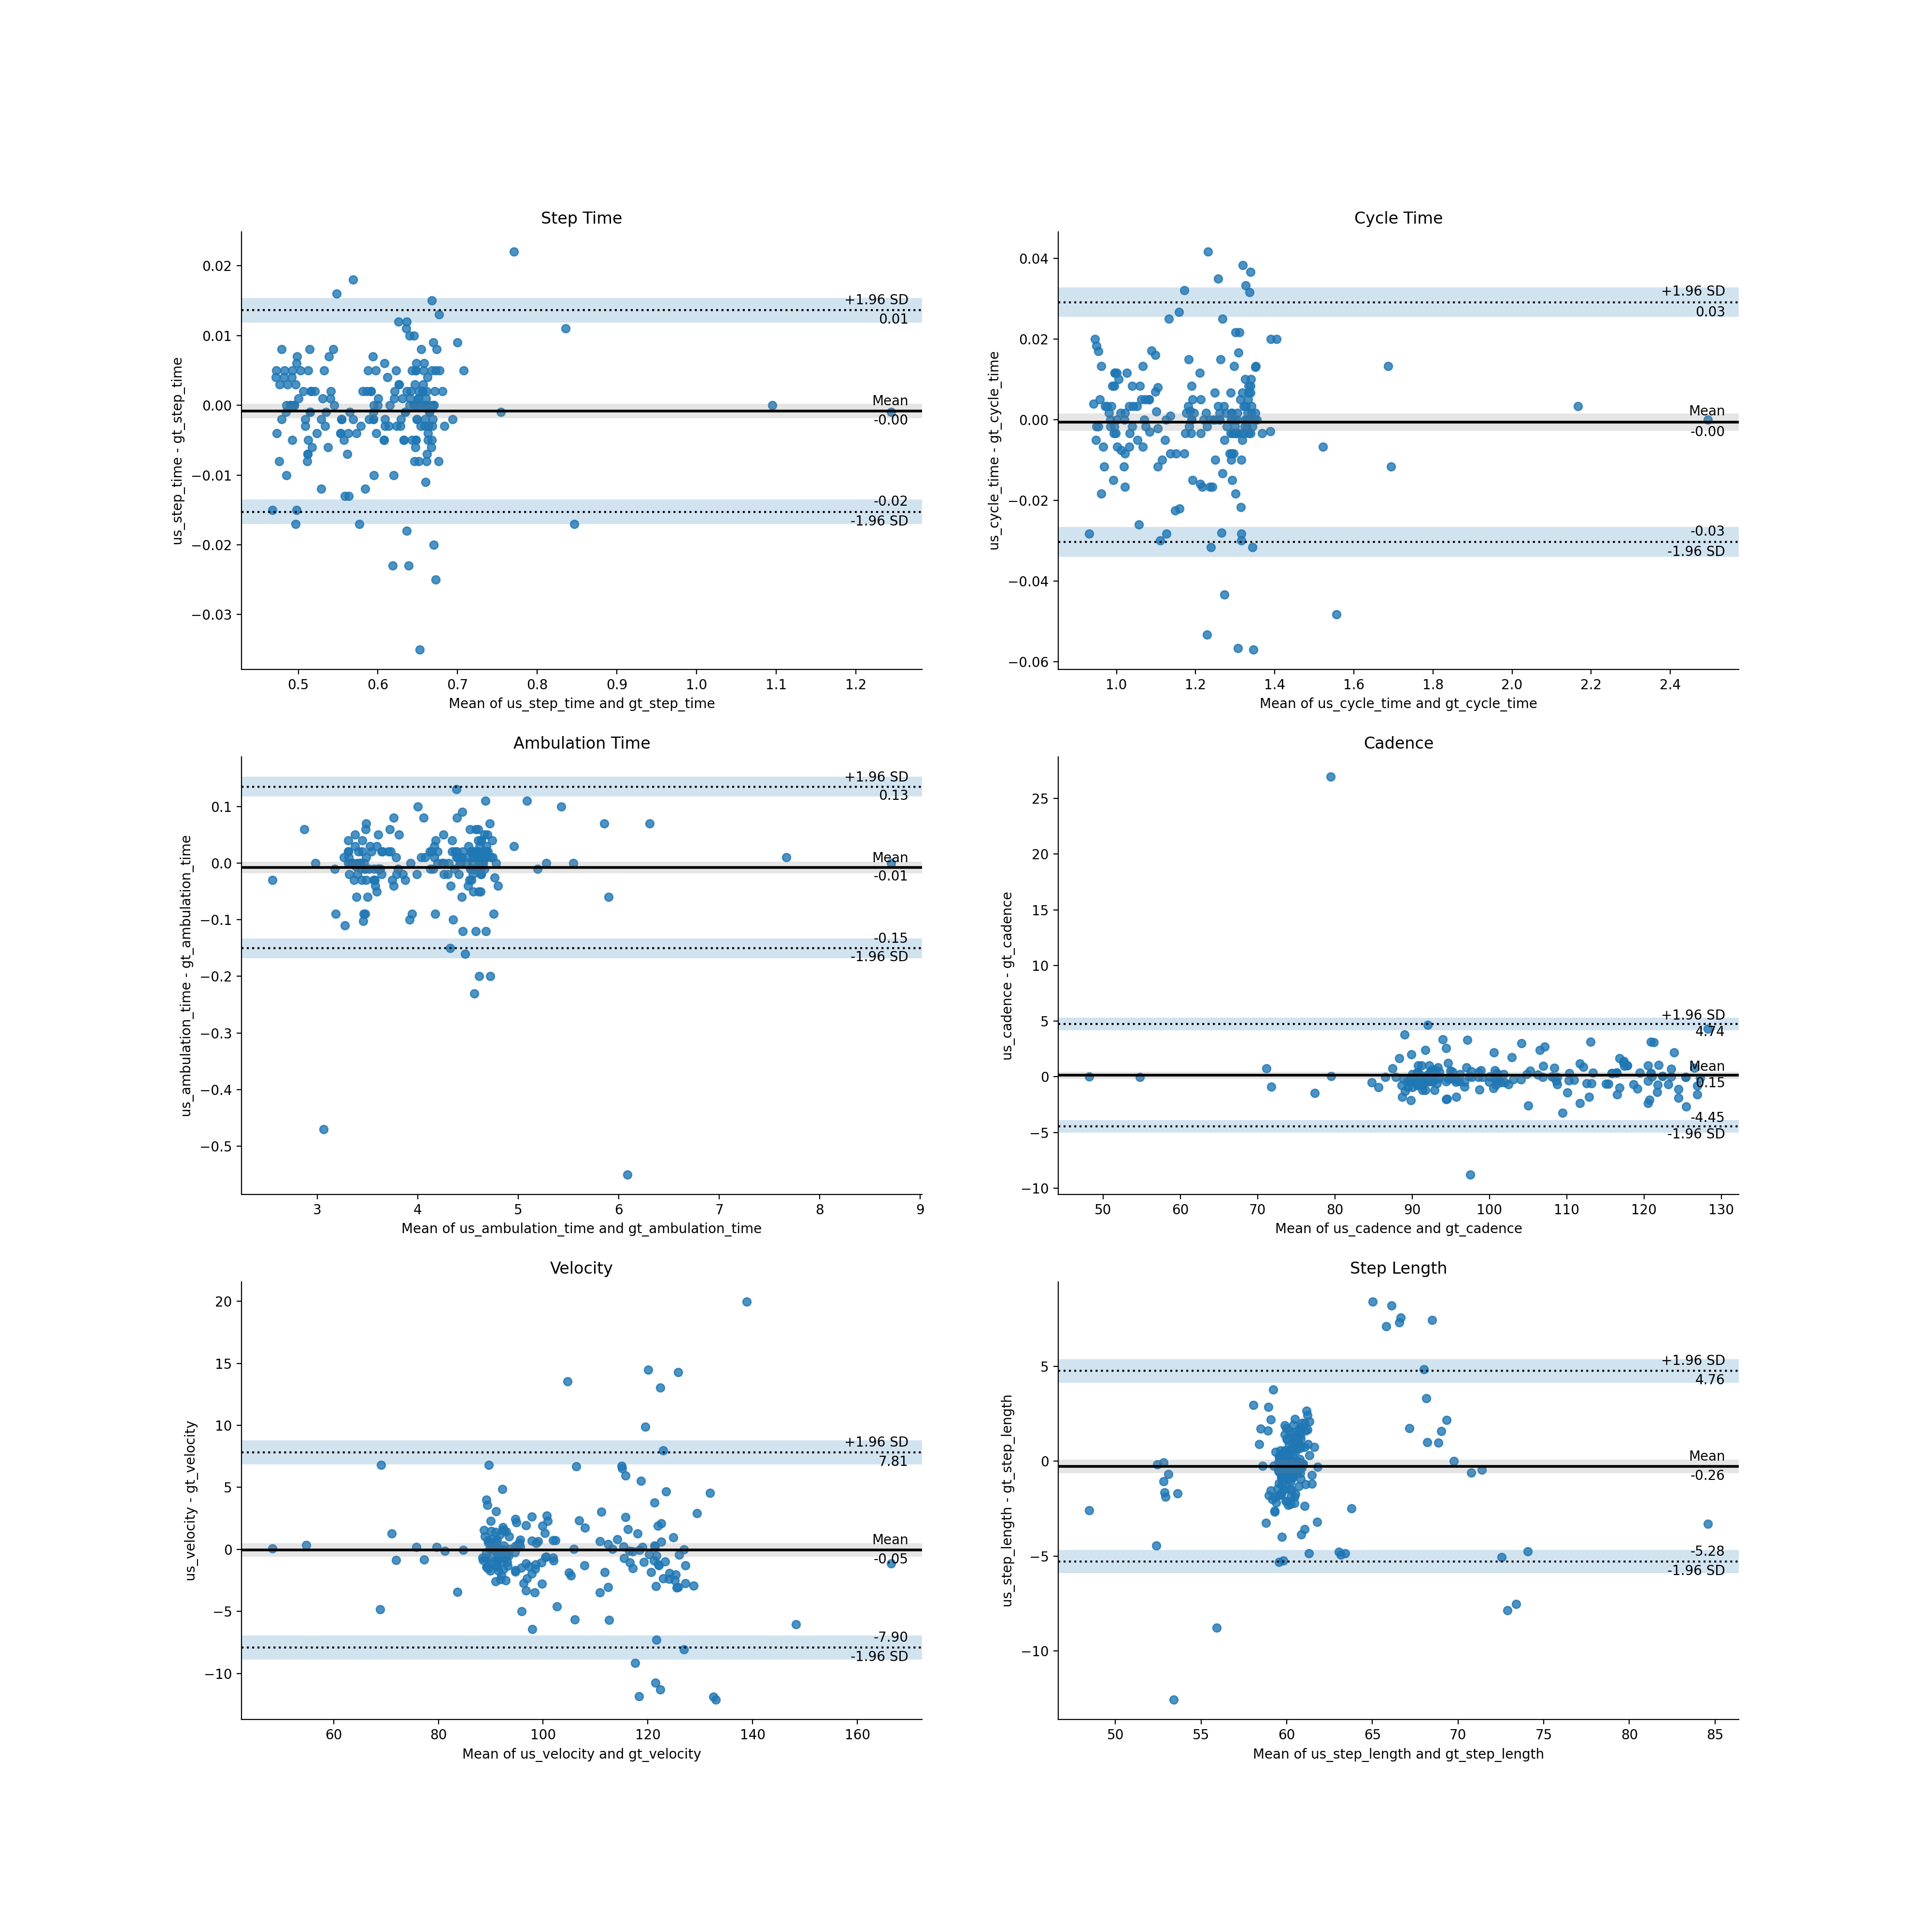

In [7]:
import numpy as np
import pingouin as pg

def perform_ba(_ax, a, b, title):
    _ax.set_title(title)
    ax = pg.plot_blandaltman(a, b, ax=_ax)
    ax.plot()

fig, axs = plt.subplots(3, 2, figsize=(20, 20))

perform_ba(axs[0][0], b=statistic_df.gt_step_time / 1000.0, a=statistic_df.us_step_time / 1000.0, title="Step Time")
perform_ba(axs[0][1], b=statistic_df.gt_cycle_time / 1000.0, a=statistic_df.us_cycle_time / 1000.0, title="Cycle Time")
perform_ba(axs[1][0], b=statistic_df.gt_ambulation_time / 1000.0, a=statistic_df.us_ambulation_time / 1000.0, title="Ambulation Time")
perform_ba(axs[1][1], b=statistic_df.gt_cadence, a=statistic_df.us_cadence, title="Cadence")
perform_ba(axs[2][0], b=statistic_df.gt_velocity, a=statistic_df.us_velocity, title="Velocity")
perform_ba(axs[2][1], b=statistic_df.gt_step_length, a=statistic_df.us_step_length, title="Step Length")

plt.show()

<IPython.core.display.Javascript object>


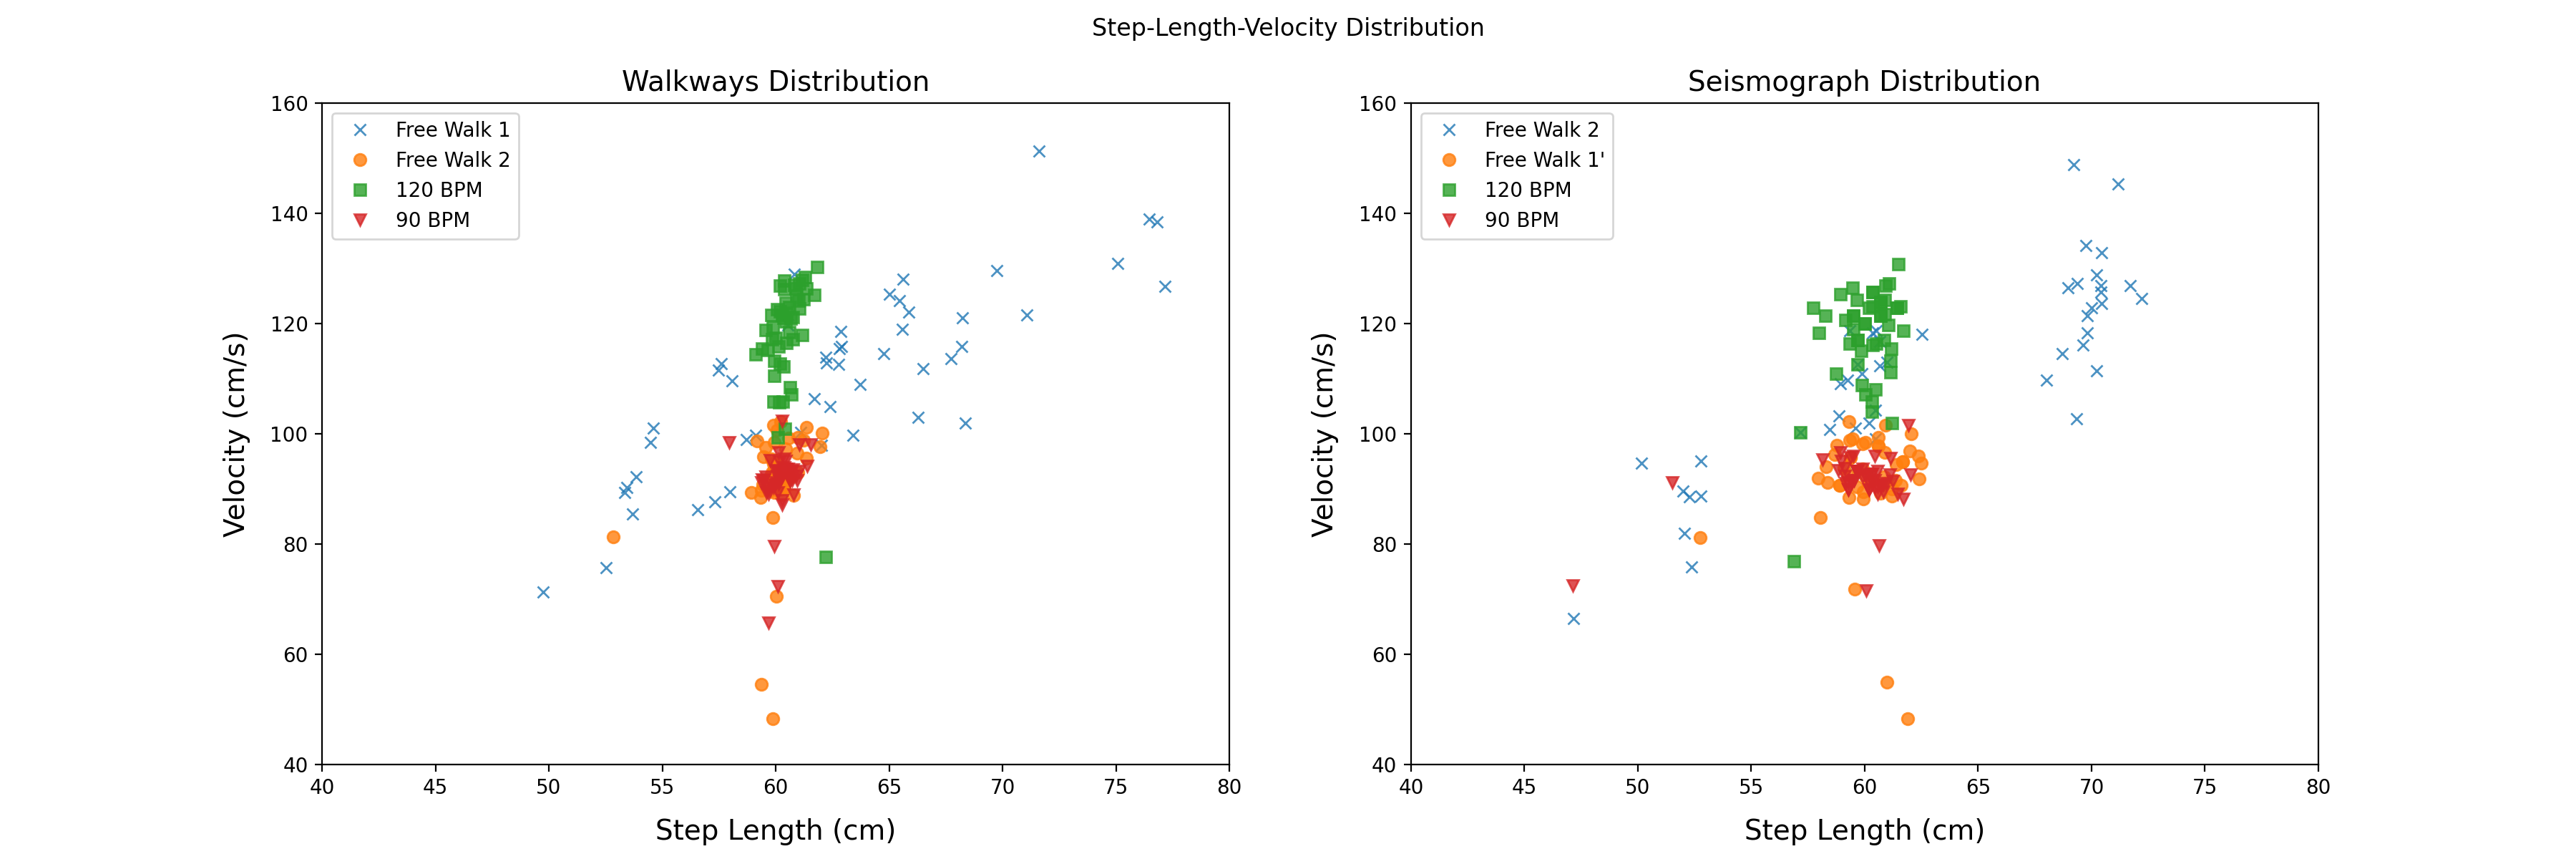

Velocity:
mean gt 103.035
std gt 16.60310437839864
mean us 102.98748138207587
mean us 16.529409557655764
min gt 48.3
max gt 167.0
min us 48.36555683122847
max us 165.851968503937
Step Length
mean gt 60.9968
std gt 3.917800276941131
mean us 60.73667877588504
std us 4.200068728051095
min gt 49.755
max gt 86.235
min us 47.12936316695353
max us 82.9259842519685
Step Time
  mean gt:  604.05
  std gt:  92.19054994954743
  min gt:  470.0
  max gt:  1245.0

  mean us:  603.225
  std us:  92.43421647312212
  min us:  460.0
  max us:  1244.0
Cycle Time
  mean gt:  1206.025
  std gt:  185.5224363116224
  min gt:  935.0
  max gt:  2495.0

  mean us:  1205.4288095238094
  std us:  185.1304216531828
  min us:  916.6666666666666
  max us:  2495.0
Ambulation Time
  mean gt:  4206.4
  std gt:  736.628155856128
  min gt:  2570.0
  max gt:  8710.0

  mean us:  4198.535
  std us:  737.0087779497609
  min us:  2540.0
  max us:  8710.0
Cadence
  mean gt:  101.2295
  std gt:  13.780387503622677
  min gt:  48

In [8]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as md

np.sum(np.array(statistic_df["step_count"]))
a = 0.8
## Condenced
xfmt = md.DateFormatter('%H:%M:%S')
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

fig.suptitle(f"Step-Length-Velocity Distribution")

axs[0].plot(np.array(statistic_df[statistic_df.experiment_nr == 0].gt_step_length), np.array(statistic_df[statistic_df.experiment_nr == 0].gt_velocity), "x", alpha=a, label="Free Walk 1".format("x"))
axs[0].plot(np.array(statistic_df[statistic_df.experiment_nr == 1].gt_step_length), np.array(statistic_df[statistic_df.experiment_nr == 1].gt_velocity), "o", alpha=a, label="Free Walk 2".format("o"))    
axs[0].plot(np.array(statistic_df[statistic_df.experiment_nr == 2].gt_step_length), np.array(statistic_df[statistic_df.experiment_nr == 2].gt_velocity), "s", alpha=a, label="120 BPM".format("s"))
axs[0].plot(np.array(statistic_df[statistic_df.experiment_nr == 3].gt_step_length), np.array(statistic_df[statistic_df.experiment_nr == 3].gt_velocity), "v", alpha=a, label="90 BPM".format("v"))
axs[0].legend(numpoints=1)
axs[0].set_xlim((40, 80))
axs[0].set_ylim((40, 160))
axs[0].set_title("Walkways Distribution", fontsize=14)
axs[0].set_xlabel("Step Length (cm)", fontsize=14, labelpad=10)
axs[0].set_ylabel("Velocity (cm/s)", fontsize=14, labelpad=10)

axs[1].plot(np.array(statistic_df[statistic_df.experiment_nr == 0].us_step_length), np.array(statistic_df[statistic_df.experiment_nr == 0].us_velocity), "x", alpha=a, label="Free Walk 2".format("x"))
axs[1].plot(np.array(statistic_df[statistic_df.experiment_nr == 1].us_step_length), np.array(statistic_df[statistic_df.experiment_nr == 1].us_velocity), "o", alpha=a, label="Free Walk 1'".format("o"))    
axs[1].plot(np.array(statistic_df[statistic_df.experiment_nr == 2].us_step_length), np.array(statistic_df[statistic_df.experiment_nr == 2].us_velocity), "s", alpha=a, label="120 BPM ".format("s"))
axs[1].plot(np.array(statistic_df[statistic_df.experiment_nr == 3].us_step_length), np.array(statistic_df[statistic_df.experiment_nr == 3].us_velocity), "v", alpha=a, label="90 BPM".format("v"))
axs[1].legend(numpoints=1)
axs[1].set_xlim((40, 80))
axs[1].set_ylim((40, 160))
axs[1].set_title("Seismograph Distribution", fontsize=14)
axs[1].set_xlabel("Step Length (cm)", fontsize=14, labelpad=10)
axs[1].set_ylabel("Velocity (cm/s)", fontsize=14, labelpad=10)


plt.show()


## END


print("Velocity:")
print("mean gt", np.mean(statistic_df.gt_velocity))
print("std gt", np.std(statistic_df.gt_velocity))
print("mean us", np.mean(statistic_df.us_velocity))
print("mean us", np.std(statistic_df.us_velocity))
print("min gt", np.min(statistic_df.gt_velocity))
print("max gt", np.max(statistic_df.gt_velocity))
print("min us", np.min(statistic_df.us_velocity))
print("max us", np.max(statistic_df.us_velocity))


def report_descriptive_statistics(gt, us, label):
    print(label)
    print("  mean gt: ", np.mean(gt))
    print("  std gt: ", np.std(gt))
    print("  min gt: ", np.min(gt))
    print("  max gt: ", np.max(gt))
    print()
    print("  mean us: ", np.mean(us))
    print("  std us: ", np.std(us))
    print("  min us: ", np.min(us))
    print("  max us: ", np.max(us))
    
    
print("Step Length")
print("mean gt", np.mean(statistic_df.gt_step_length))
print("std gt", np.std(statistic_df.gt_step_length))
print("mean us", np.mean(statistic_df.us_step_length))
print("std us", np.std(statistic_df.us_step_length))
print("min gt", np.min(statistic_df.gt_step_length))
print("max gt", np.max(statistic_df.gt_step_length))
print("min us", np.min(statistic_df.us_step_length))
print("max us", np.max(statistic_df.us_step_length))


report_descriptive_statistics(gt=statistic_df.gt_step_time, us=statistic_df.us_step_time, label="Step Time")
report_descriptive_statistics(gt=statistic_df.gt_cycle_time, us=statistic_df.us_cycle_time, label="Cycle Time")
report_descriptive_statistics(gt=statistic_df.gt_ambulation_time, us=statistic_df.us_ambulation_time, label="Ambulation Time")
report_descriptive_statistics(gt=statistic_df.gt_cadence, us=statistic_df.us_cadence, label="Cadence")
report_descriptive_statistics(gt=statistic_df.gt_velocity, us=statistic_df.us_velocity, label="Velocity")
report_descriptive_statistics(gt=statistic_df.gt_step_length, us=statistic_df.us_step_length, label="Step Length")